# Exploratory Data Analysis Notebook

Welcome to the Exploratory Data Analysis (EDA) Notebook. EDA is all about understanding the data, gaining insights, and identifying patterns which will inform how we model the data.

In this part of the project, we're going to dig into our movie data to see what makes a movie successful. We're looking at success in three different ways:

**Return on Investment (ROI):**

ROI is a performance measure used to evaluate the efficiency or profitability of an investment, or to compare the efficiency of different investments. In the context of movies, it's computed as the ratio of revenue to budget. This metric is crucial as it helps investors understand the financial return they might expect from their investment in a particular movie. It's a clear indicator of financial success.

**Rating Metric:**
Ratings are critical in the movie industry as they reflect the audience's reception. In this analysis, we intend to aggregate ratings from different rating systems to form an overall rating metric. This will provide a more holistic view of a movie's reception across various platforms and audiences.

**Awards Metric:**
Awards and nominations are a testament to a movie's quality and acceptance within the industry. They can significantly boost a movie's reputation and, by extension, its financial success. Creating an awards metric will help in understanding the recognition a movie has received in the industry.

Now, we'll go through our data, looking at how different bits of information (like the movie's genre or the month it was released) might affect these three success measures. This will help us later when we build our model to predict a movie's success.

## Objectives:
- **Distribution Analysis**: Understanding the distribution of various features.
- **Outlier Detection**: Detecting and handling outliers.
- **Correlation Analysis**: Identifying relationships between different variables.
- **Trend Analysis**: Discovering trends within the data.
- **Feature Engineering**: Creating new features to better capture the underlying patterns in the data.

## Dataset:
In this notebook, we will be working with the cleaned dataset located at `./data/cleaned/movies_dataset.parquet`, which is the result of the cleaning process carried out in the preceding Data Cleaning Notebook.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [3]:
df = pd.read_parquet('../data/cleaned/movies_dataset.parquet')

In [4]:
# Set the float format to display the entire number
pd.options.display.float_format = '{:.2f}'.format
df.describe().style

array([[<Axes: title={'center': 'release_year'}>,
        <Axes: title={'center': 'release_month'}>,
        <Axes: title={'center': 'runtime'}>,
        <Axes: title={'center': 'tmdb_popularity'}>],
       [<Axes: title={'center': 'tmdb_rating'}>,
        <Axes: title={'center': 'tmdb_vote_count'}>,
        <Axes: title={'center': 'oscar_won'}>,
        <Axes: title={'center': 'oscar_nominated'}>],
       [<Axes: title={'center': 'bafta_won'}>,
        <Axes: title={'center': 'bafta_nominated'}>,
        <Axes: title={'center': 'awards_won'}>,
        <Axes: title={'center': 'awards_nominated'}>],
       [<Axes: title={'center': 'rotten_tomatoes_rating'}>,
        <Axes: title={'center': 'metacritic_rating'}>,
        <Axes: title={'center': 'imdb_rating'}>,
        <Axes: title={'center': 'imdb_votes'}>],
       [<Axes: title={'center': 'adjusted_budget'}>,
        <Axes: title={'center': 'adjusted_revenue'}>,
        <Axes: title={'center': 'adjusted_boxoffice'}>, <Axes: >]],
      

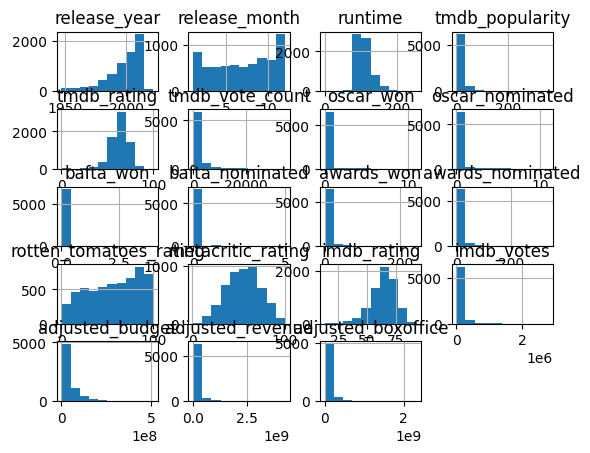

In [5]:
df.hist()

### ROI

First of all, I'm going to calculate ROI. ROI is calculated by taking the total revenue of a movie, subtracting the budget, and then dividing by the budget once more.

Formula (revenue - budget) / budget * 100%

Now, why do we use the revenue and budget columns to calculate ROI and not consider the BoxOffice column?

The revenue column typically represents the global revenue generated by a movie, encompassing not just box office revenue but also other revenue streams like home video sales, TV rights, and merchandise. Also, the revenue and budget columns have more complete data as compared to the BoxOffice column, which has a number of missing values. Utilizing columns with more complete data allows for a more accurate and reliable calculation of ROI.


In [6]:
df[['adjusted_budget', 'adjusted_revenue', 'adjusted_boxoffice']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6769 entries, 0 to 7086
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   adjusted_budget     6769 non-null   float64
 1   adjusted_revenue    6769 non-null   float64
 2   adjusted_boxoffice  5354 non-null   float64
dtypes: float64(3)
memory usage: 211.5 KB


Look at characteristics of revenue and budget in our dataset
Plot log and non logged dat

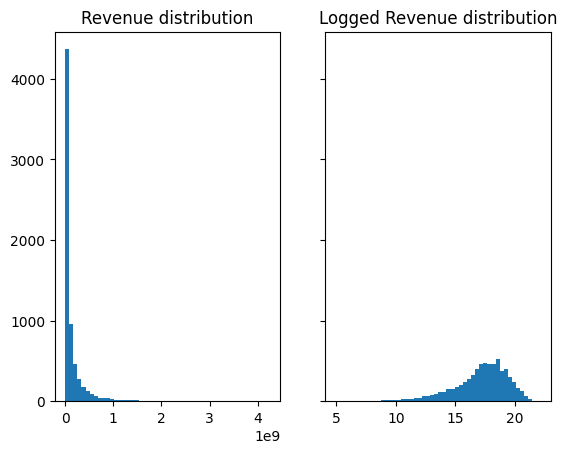

In [97]:
#Plot movie revenue data both logged and non logged
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(df['adjusted_revenue'], bins=50)
axs[0].set_title('Revenue distribution')
axs[1].hist(np.log(df['adjusted_revenue']), bins=50)
axs[1].set_title('Logged Revenue distribution')
plt.show()

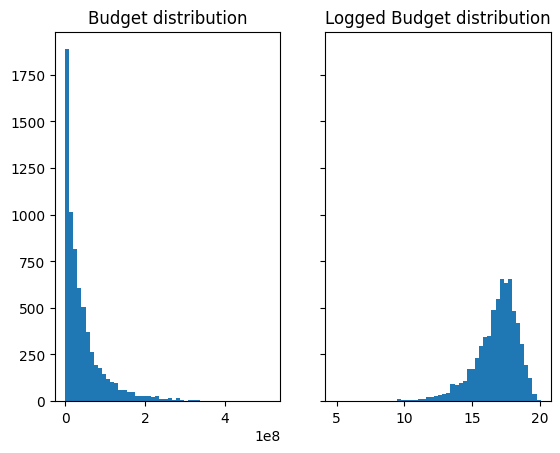

In [98]:
#Plot movie budget data both logged and non logged
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(df['adjusted_budget'], bins=50)
axs[0].set_title('Budget distribution')
axs[1].hist(np.log(df['adjusted_budget']), bins=50)
axs[1].set_title('Logged Budget distribution')
plt.show()

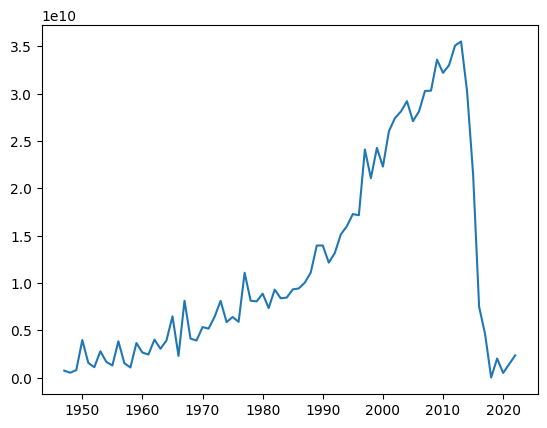

In [99]:
#Print out yearly adjusted revenue
#!TODO: why it fails down
plot_rev = df.groupby(['release_year'])['adjusted_revenue'].agg('sum')
plt.plot(plot_rev )

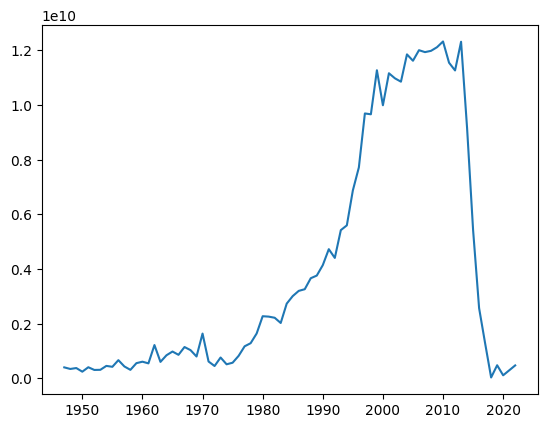

In [100]:
#Print out yearly adjusted revenue
#!TODO: why it fails down
plot_rev = df.groupby(['release_year'])['adjusted_budget'].agg('sum')
plt.plot(plot_rev)

In [101]:
df['adjusted_ROI'] = ((df['adjusted_revenue'] - df['adjusted_budget']) / df['adjusted_budget']) * 100


In [102]:
styled_description = df[['adjusted_ROI']].describe().style
styled_description

It's evident that the distribution of ROI (Return on Investment) is highly skewed with extreme outliers. This huge discrepancy between the maximum value and the 75th percentile, along with the large standard deviation, confirms the presence of extreme outliers in the data.

Let's look at what percentile our outliers lie and how many and what those movies are.

0.75      289.12
0.95     1361.54
0.99     6915.70
0.99    11343.81
1.00   499900.00
Name: adjusted_ROI, dtype: float64


/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


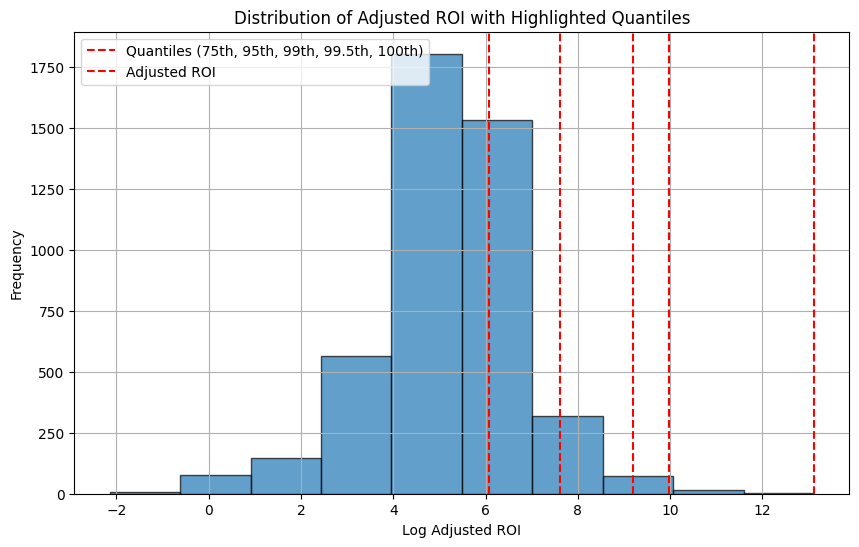

In [11]:
set_df = df.copy()
percentiles = df['adjusted_ROI'].quantile([0.75, 0.95, 0.99, 0.995, 1])
print(percentiles)

# let's see quantiles on the graph, but first let's apply log adjusted_ROI for better visualization and analysis

import numpy as np
set_df['log_adjusted_ROI'] = np.log1p(set_df['adjusted_ROI'])
log_quantiles = set_df['log_adjusted_ROI'].quantile([0.75, 0.95, 0.99, 0.995, 1])

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(set_df['log_adjusted_ROI'], bins=10, edgecolor='k', alpha=0.7)
for quantile in log_quantiles:
    plt.axvline(x=quantile, color='red', linestyle='--')
plt.xlabel('Log Adjusted ROI')
plt.ylabel('Frequency')
plt.title('Distribution of Adjusted ROI with Highlighted Quantiles')
plt.legend(['Quantiles (75th, 95th, 99th, 99.5th, 100th)', 'Adjusted ROI'])
plt.grid(True)
plt.show()


So you can see that outliers is somewhere between 99.5% and 100%. Let's see the list of the most profitable movies

In [12]:
quantile_99 = set_df['adjusted_ROI'].quantile(0.995)
max_value = set_df['adjusted_ROI'].max()  # This corresponds to the 100th percentile

count_between = set_df[(set_df['adjusted_ROI'] > quantile_99) & (set_df['adjusted_ROI'] <= max_value)].shape[0]

print(f'Number of values between 99th and 100th percentiles: {count_between}')

set_df[(set_df['adjusted_ROI'] > quantile_99) & (set_df['adjusted_ROI'] <= max_value)][['title', "adjusted_ROI"]].sort_values(by='adjusted_ROI', ascending=False)


Number of values between 99th and 100th percentiles: 34


title  adjusted_ROI
6845                                            saved     499900.00
2099                          the blair witch project     414298.50
4686                                      deep throat     399900.00
1937                                 1 night in paris     178631.01
5604                                      smithereens     100789.25
2823                                       angel town      99994.74
3393                                   american adobo      99567.15
5325                              paranormal activity      89832.93
2607                                lady frankenstein      69741.50
1961                            aloha, bobby and rose      58233.33
581                                    pink flamingos      49900.00
953                                        open water      41952.27
3699                            behind the green door      41566.67
3456                                         monopoly      37687.12
998                      the texas chain saw massacre      36252.94
2271                                          mad max      28471.43
273                                       el mariachi      28148.03
4712                                 the stewardesses      26900.00
3015                         night of the living dead      26215.79
4548                                     the mistress      26182.00
2745                                            rocky      22425.04
30    alice in wonderland: an x-rated musical fantasy      22400.00
5273                                        halloween      21522.77
3702                               the zombie diaries      21405.38
337                             the way of the dragon      20669.23
1938                                              joe      18125.71
5064                                american graffiti      17918.02
40                                  let's do it again      16757.14
2663                      a polish vampire in burbank      16566.67
3586                                      blood feast      16226.53
535                                        easy rider      14900.00
3316                        the legend of boggy creek      13650.00
4677                                             once      12844.07
4364                                napoleon dynamite      11429.52

I checked first 2 outliers - https://en.wikipedia.org/wiki/The_Blair_Witch_Project and https://en.wikipedia.org/wiki/Deep_Throat_(film) and they indeed have very high ROI so they look legit.

Additionaly, I googled 'good ROI in movie industry' so I got different answers, but most of them were "3x its budget". This rule suggests that for a movie to be considered financially successful, it should earn at least three times its production budget. This is because the production budget often only accounts for the costs of filming. There are many other expenses, like marketing, distribution, and operational costs, that are also incurred during a movie's release.

If you look at ROI distribution you also might notice that ROI=300 is almost 75th percentile.

Here's how we'll label the ROI based on the "3x its budget" rule to indicate whether a movie is a hit or a flop:

- **ROI < 300% (or 3x its budget): Flop**

If a movie's ROI is less than 300%, it means the revenue generated didn't cover the production budget and the additional expenses to a satisfactory extent. It's a sign of financial underperformance, and hence, we label it as a 'flop'.

- **ROI ≥ 300% (or 3x its budget): Hit**

Conversely, if a movie's ROI is 300% or higher, it suggests that the revenue generated was substantial, covering the production budget and the additional expenses, with a healthy profit margin. Therefore, we label it as a 'hit'.
Labeling movies in this manner will help us, and any potential investors or stakeholders, quickly identify the financial performance of movies in our dataset

In [13]:
def categorize_roi(roi):
    if roi < 300:
        return 'flop'
    else:
        return 'hit'

df['ROI_category'] = df['adjusted_ROI'].apply(categorize_roi)

label_mapping = {
    'flop': 0,
    'hit': 1
}
df['numerical_ROI_category'] = df['ROI_category'].map(label_mapping)

df.drop(['ROI_category', 'adjusted_boxoffice', 'adjusted_budget', 'adjusted_revenue'], axis=1, inplace=True)
#df.drop(['ROI_category', 'adjusted_ROI', 'adjusted_boxoffice', 'adjusted_budget', 'adjusted_revenue'], axis=1, inplace=True)

### Ratings

In [103]:
print(df[['tmdb_rating', 'tmdb_vote_count',  'imdb_rating', 'imdb_votes', 'rotten_tomatoes_rating', 'metacritic_rating']].info())
df[['tmdb_rating', 'tmdb_vote_count',  'imdb_rating', 'imdb_votes', 'rotten_tomatoes_rating', 'metacritic_rating']].describe().transpose()

<class 'pandas.core.frame.DataFrame'>
Index: 6769 entries, 0 to 7086
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tmdb_rating             6769 non-null   float64
 1   tmdb_vote_count         6769 non-null   int64  
 2   imdb_rating             6764 non-null   float64
 3   imdb_votes              6766 non-null   float64
 4   rotten_tomatoes_rating  5697 non-null   float64
 5   metacritic_rating       5046 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 370.2 KB
None


count     mean       std   min     25%      50%  \
tmdb_rating            6769.00    63.04      9.54  0.00   58.00    63.60   
tmdb_vote_count        6769.00  1651.85   3079.33  0.00  128.00   516.00   
imdb_rating            6764.00    63.59     10.73 13.00   57.00    65.00   
imdb_votes             6766.00 99031.65 194063.67 12.00 8363.00 32195.50   
rotten_tomatoes_rating 5697.00    56.07     27.92  0.00   33.00    59.00   
metacritic_rating      5046.00    55.36     18.21  1.00   42.00    56.00   

                             75%        max  
tmdb_rating                69.27     100.00  
tmdb_vote_count          1695.00   34612.00  
imdb_rating                71.00      93.00  
imdb_votes             104135.25 2802199.00  
rotten_tomatoes_rating     81.00     100.00  
metacritic_rating          68.00     100.00

/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


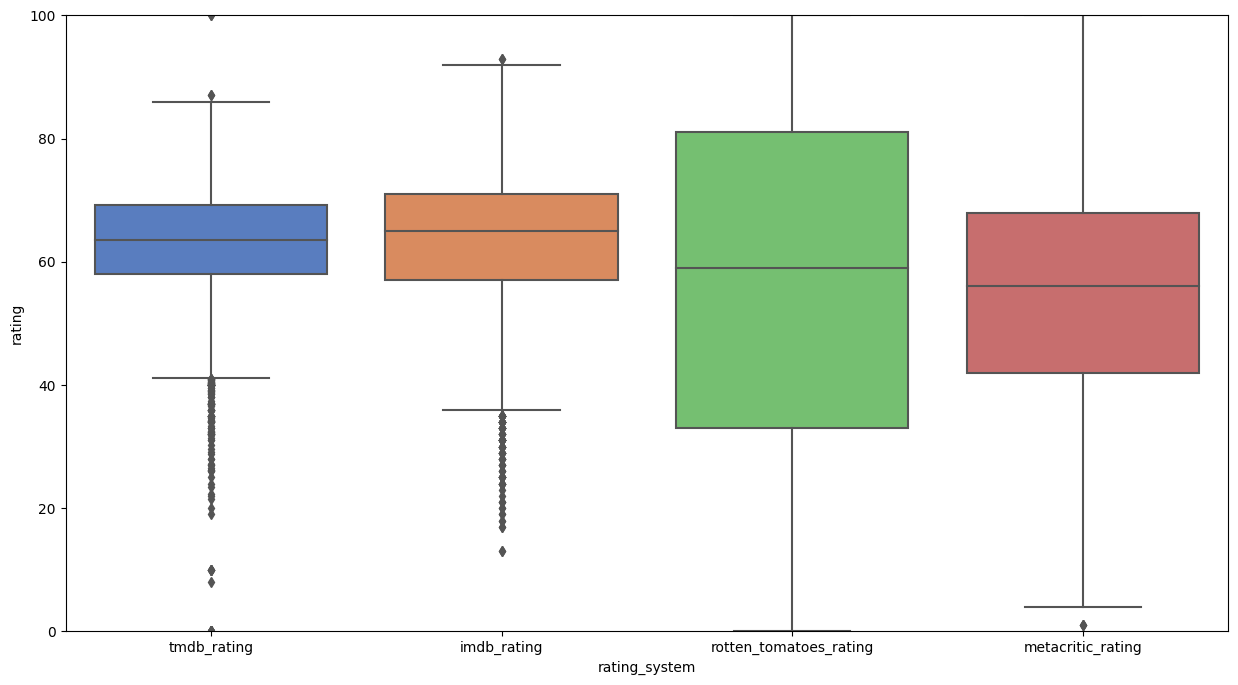

In [15]:
melted_df = df.melt(value_vars=['tmdb_rating', 'imdb_rating', 'rotten_tomatoes_rating', 'metacritic_rating'],
                    var_name='rating_system', value_name='rating')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
sns.boxplot(x='rating_system', y='rating', data=melted_df, palette="muted", ax=ax)
ax.set_ylim([0, 100])  

plt.show()

In [16]:
zero_counts = (df[['tmdb_rating', 'tmdb_vote_count',  'imdb_rating', 'imdb_votes', 'rotten_tomatoes_rating', 'metacritic_rating']] == 0).sum()

print(zero_counts)


tmdb_rating               12
tmdb_vote_count           12
imdb_rating                0
imdb_votes                 0
rotten_tomatoes_rating    72
metacritic_rating          0
dtype: int64


In our dataset, we have access to the number of votes a movie has received on both TMDB (tmdb_vote_count) and IMDb (imdb_votes). It's a well-observed phenomenon that the rating of a movie can significantly depend on the number of votes it has received; a movie with a higher number of votes is likely to have a more reliable rating as compared to a movie with fewer votes. This is because a larger voting pool reduces the chance of skewed ratings.

To account for this voting discrepancy and to provide a balanced view of a movie's rating, I will apply a Weighted Rating Formula. This formula not only considers the average rating of a movie but also the number of votes it has garnered. By doing so, it gives us a more conservative estimate of a movie’s rating, particularly when the movie has fewer votes. This weighted rating thus corrects the bias in rating due to a varied number of votes, offering a more accurate reflection of a movie's popularity and quality. 

**Adjusting Ratings based on Vote Counts:**

A weighted rating formula is often used to compute a score that reflects both the average rating of an item and the number of ratings the item has received. This helps to give a more balanced view of the item's popularity and quality, compared to simply using the average rating which can be easily skewed by a small number of high or low ratings.

One common formula used for this purpose is the IMDb (Internet Movie Database) weighted rating formula, which is as follows:

Weighted Rating(WR) = (v/(v+m))*R + (m/(v+m)) * C
where:

- v is the number of votes for the item,
- m is the minimum number of votes required for the item to be listed,
- R is the average rating of the item,
- C is the mean rating across the whole dataset.

the 70th percentile (0.70 quantile) is used to set a threshold for the minimum number of votes a movie must have to be included in the weighted rating calculation. This means that only movies with a number of votes higher than 70% of the movies in the dataset will have a weighted rating significantly influenced by their own average rating. For movies with a number of votes below this threshold, the global average rating will have a more significant influence on their weighted rating.

In [8]:
m = df['tmdb_vote_count'].quantile(0.70)  # minimum votes required to be listed
C = df['tmdb_rating'].mean()  # mean rating across the whole dataset

print('tmdb minimum votes:', m)
print('tmdb mean rating across the whole dataset:', C)

# Function to compute weighted rating
def weighted_rating(x, m=m, C=C):
    v = x['tmdb_vote_count']
    R = x['tmdb_rating']
    return (v / (v + m) * R) + (m / (m + v) * C)

df['weighted_tmdb_rating'] = df.apply(weighted_rating, axis=1)

m = df['imdb_votes'].quantile(0.70)  # minimum votes required to be listed
C = df['imdb_rating'].mean()  # mean rating across the whole dataset

print('imdb minimum votes:', m)
print('imdb mean rating across the whole dataset:', C)

# Function to compute weighted rating
def weighted_rating(x, m=m, C=C):
    v = x['imdb_votes']
    R = x['imdb_rating']
    return (v / (v + m) * R) + (m / (m + v) * C)

df['weighted_imdb_rating'] = df.apply(weighted_rating, axis=1)

df[['imdb_rating', 'imdb_votes', 'weighted_tmdb_rating',  'tmdb_vote_count',  'tmdb_rating','weighted_imdb_rating', 'rotten_tomatoes_rating',	'metacritic_rating']].describe().style


tmdb minimum votes: 1341.5999999999995
tmdb mean rating across the whole dataset: 63.04286305214951
imdb minimum votes: 82400.5
imdb mean rating across the whole dataset: 63.59047900650503


The weighted rating formula helps in balancing the ratings, especially for movies with a lower number of votes. Movies with fewer votes are pulled towards the mean rating to a greater extent than movies with a higher number of votes. This reduces the likelihood of extreme ratings for movies with few votes, making the distribution of ratings more balanced and less skewed. Movies with a higher vote count have ratings that are more reflective of the general audience's opinion, and their weighted ratings are less affected by the formula. 

By regressing ratings towards the mean, the formula reduces the influence of outlier ratings. This is particularly useful when there are movies with very high or very low ratings but with a small number of votes, which could otherwise distort the overall distribution.

/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


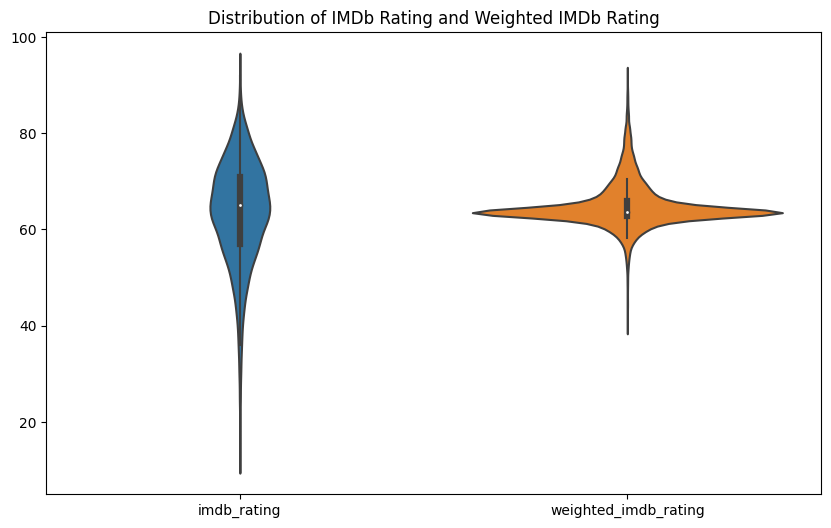

/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


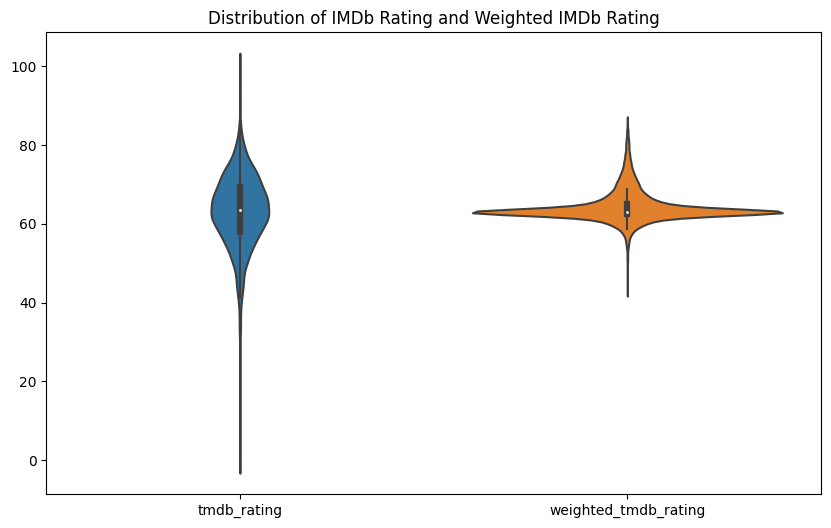

In [18]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df[['imdb_rating', 'weighted_imdb_rating']])
plt.title('Distribution of IMDb Rating and Weighted IMDb Rating')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(data=df[['tmdb_rating', 'weighted_tmdb_rating']])
plt.title('Distribution of IMDb Rating and Weighted IMDb Rating')
plt.show()


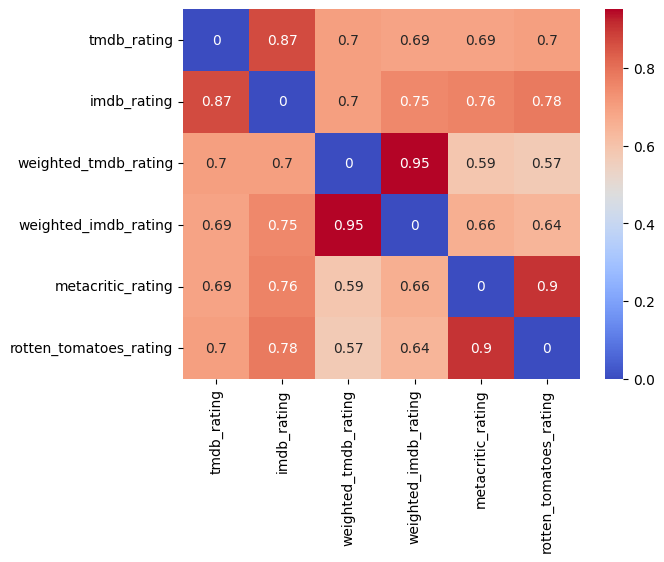

('weighted_tmdb_rating', 'weighted_imdb_rating')


In [19]:
corr_matrix = df[[ "tmdb_rating", 'imdb_rating', 
                             "weighted_tmdb_rating", 'weighted_imdb_rating', 
                             'metacritic_rating', 'rotten_tomatoes_rating']].corr()

# Compute the correlation matrix
for i in range(corr_matrix.shape[0]):
    corr_matrix.iloc[i, i] = 0

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.show()

max_corr_value = corr_matrix.abs().max().max()
result = corr_matrix.where(corr_matrix == max_corr_value).stack().index.tolist()[0]

print(result)


The correlation coefficient of 0.96 between normalized_weighted_tmdb_rating and normalized_weighted_imdb_rating indicates a very strong positive linear relationship between these two variables. It makes sense to average them separately as they might be capturing similar aspects of the movie's quality.

Also in cases where weighted_imdb_rating is null, we can take only weighted_tmdb_rating number instead

In [20]:
import numpy as np

df['average_rating'] = np.where(df['weighted_imdb_rating'].isnull(), 
                                df['weighted_tmdb_rating'], 
                                (df['weighted_tmdb_rating'] + df['weighted_imdb_rating']) / 2)


# let's look at the top rates movies
top_movies = df.sort_values(by='average_rating', ascending=False)
top_movies[['title', 'average_rating']].head(15)


title  average_rating
4852                           the shawshank redemption           88.98
4827                                      the godfather           88.16
6492                                    the dark knight           86.72
6474      the lord of the rings: the return of the king           86.21
4115                                   schindler's list           86.18
4829                              the godfather part ii           85.97
574                                        pulp fiction           85.93
915                                        forrest gump           85.40
2497                                         fight club           85.26
3519                                          inception           85.05
6472  the lord of the rings: the fellowship of the ring           84.95
5711                                       12 angry men           84.85
6473              the lord of the rings: the two towers           84.72
6769                                       interstellar           84.72
4149                                     the green mile           84.05

Currently for simplicity we aim to categorize movies into 'hit' or 'flop' based on their average ratings.
I chose a simplistic approach to label the top 25% of movies (in terms of average_rating) as 'hit', while the remaining 75% are labeled as 'flop'. This is a straightforward method to distinguish higher-rated movies from the lower-rated ones.

In [21]:
df['rating_category'] = 'flop' 
top_25_percentile_threshold = df['average_rating'].quantile(0.75)  
df.loc[df['average_rating'] >= top_25_percentile_threshold, 'rating_category'] = 'hit'  

label_mapping = {
    'flop': 0,
    'hit': 1
}
df['numerical_rating_category'] = df['rating_category'].map(label_mapping)
df.drop(['rating_category', 
                             'rotten_tomatoes_rating', 'metacritic_rating', 'imdb_rating', 'tmdb_rating',  
                             'weighted_imdb_rating', 'weighted_tmdb_rating', 'tmdb_vote_count', 'imdb_votes'], axis=1, inplace=True)


### Awards

In [22]:
df[['oscar_won',   'oscar_nominated', 'bafta_won', 'bafta_nominated', 'awards_won', 'awards_nominated']].describe()

oscar_won  oscar_nominated  bafta_won  bafta_nominated  awards_won  \
count    6769.00          6769.00    6769.00          6769.00     6769.00   
mean        0.15             0.23       0.01             0.03        5.73   
std         0.76             0.83       0.11             0.21       14.66   
min         0.00             0.00       0.00             0.00        0.00   
25%         0.00             0.00       0.00             0.00        0.00   
50%         0.00             0.00       0.00             0.00        1.00   
75%         0.00             0.00       0.00             0.00        5.00   
max        11.00            11.00       4.00             5.00      245.00   

       awards_nominated  
count           6769.00  
mean              10.62  
std               21.84  
min                0.00  
25%                1.00  
50%                4.00  
75%               11.00  
max              337.00

In [23]:
# Top 10 movies by oscar_won
top10_oscar_won = df.nlargest(10, 'oscar_won')

# Top 10 movies by bafta_won
top10_bafta_won = df.nlargest(10, 'bafta_won')

# Top 10 movies by awards_won
top10_awards_won = df.nlargest(10, 'awards_won')

print("Top 10 movies by Oscar wins:")
print(top10_oscar_won[['title', 'oscar_won']])

print("\nTop 10 movies by BAFTA wins:")
print(top10_bafta_won[['title', 'bafta_won']])

print("\nTop 10 movies by Total awards won:")
print(top10_awards_won[['title', 'awards_won']])


Top 10 movies by Oscar wins:
                                              title  oscar_won
562                                         ben-hur         11
2532                                        titanic         11
6474  the lord of the rings: the return of the king         11
1355                                west side story         10
3279                                           gigi          9
3632                               the last emperor          9
4109                            the english patient          9
555                               on the waterfront          8
1682                                   my fair lady          8
1806                          from here to eternity          8

Top 10 movies by BAFTA wins:
                                        title  bafta_won
4692                         a bridge too far          4
3056                        strictly ballroom          3
83                       pink floyd: the wall          2
1120                

I referred to this link to gather some additional info on movie awards: https://www.imdb.com/title/<IMDB_ID>/awards/. The columns awards_won and awards_nominated obviously represent the total count of all awards won and nominated respectively.

For instance, if we consider 'The Lord of the Rings: The Return of the King' (link) or 'Titanic' (link), it's evident from the dataset that only the Oscars are mentioned. However, there's no mention of BAFTA awards, which might suggest that the dataset primarily highlights the most prestigious award(s) a movie has received.

Let's check my theory if we have for any movie oscar and bafta together:

In [24]:

titles_of_interest = ['titanic', 'the lord of the rings: the return of the king']
filtered_rows = df[df['title'].isin(titles_of_interest)]
print(filtered_rows[['oscar_won',   'oscar_nominated', 'bafta_won', 'bafta_nominated', 'awards_won', 'awards_nominated']])

non_empty_awards_rows = df[(df['oscar_won'].notnull() & df['oscar_won'] > 0) & (df['bafta_won'].notnull() & df['bafta_won'] > 0)]
print(non_empty_awards_rows)

      oscar_won  oscar_nominated  bafta_won  bafta_nominated  awards_won  \
1206          1                0          0                0           1   
2532         11                0          0                0         126   
6474         11                0          0                0         215   

      awards_nominated  
1206                 3  
2532                83  
6474               124  
Empty DataFrame
Columns: [title, release_year, release_month, original_language, spoken_languages, genres, production_companies, production_countries, runtime, rated, tagline, overview, plot, tmdb_popularity, cast, crew, belongs_to_collection.name, oscar_won, oscar_nominated, bafta_won, bafta_nominated, awards_won, awards_nominated, adjusted_ROI, numerical_ROI_category, average_rating, numerical_rating_category]
Index: []

[0 rows x 27 columns]


We can create a Points System to combine these awards into one score. We'll give more points for winning awards and some extra points for nominations. Oscars will get the highest points, followed by BAFTA, and then other awards. We'll also take out the BAFTA and Oscar counts from the total awards number.

Points:

Oscar Win: 5 points
Oscar Nomination: 3 points
BAFTA Win: 4 points
BAFTA Nomination: 2 points
Other Award Win: 3 points
Other Award Nomination: 1 point"

In [25]:
df['award_points'] = (df['oscar_won'] * 5 + df['oscar_nominated'] * 3 +
                      df['bafta_won'] * 4 + df['bafta_nominated'] * 2 +
                      (df['awards_won'] - df['oscar_won'] - df['bafta_won']) * 3 + 
                      (df['awards_nominated'] - df['oscar_nominated'] - df['bafta_nominated']) * 1)

df[['award_points', 'oscar_won',   'oscar_nominated', 'bafta_won', 'bafta_nominated', 'awards_won', 'awards_nominated']]

award_points  oscar_won  oscar_nominated  bafta_won  bafta_nominated  \
0                0          0                0          0                0   
1                0          0                0          0                0   
2               43          4                0          0                0   
4                3          0                0          0                0   
5                3          0                0          0                0   
...            ...        ...              ...        ...              ...   
7082             0          0                0          0                0   
7083             9          0                0          0                0   
7084            16          0                0          0                0   
7085             0          0                0          0                0   
7086            10          0                0          0                0   

      awards_won  awards_nominated  
0              0                 0  
1              0                 0  
2              9                 8  
4              0                 3  
5              0                 3  
...          ...               ...  
7082           0                 0  
7083           2                 3  
7084           2                10  
7085           0                 0  
7086           2                 4  

[6769 rows x 7 columns]

count   6769.00
mean      28.63
std       64.52
min        0.00
25%        2.00
50%        8.00
75%       26.00
max     1069.00
Name: award_points, dtype: float64


/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


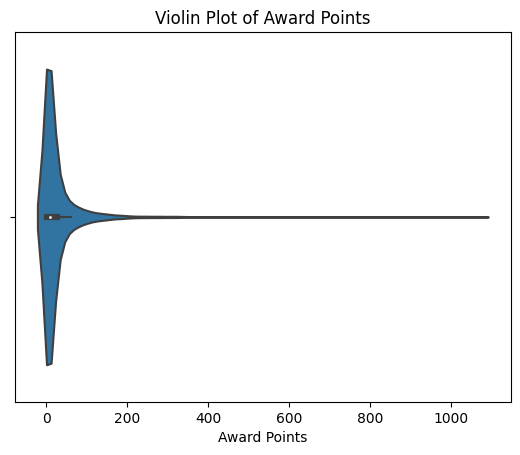

In [26]:
print(df['award_points'].describe())
sns.violinplot(x=df['award_points'])
plt.title('Violin Plot of Award Points')
plt.xlabel('Award Points')
plt.show()


the top 25% of the movies based on award points are labeled as 'hit' while the rest are labeled as 'flop'. This threshold is chosen to maintain consistency with the methodology applied to other metrics like ROI and average ratings. 

In [27]:
# Determine the 75th percentile value
threshold = df['award_points'].quantile(0.75)

df['award_category'] = ['hit' if x >= threshold else 'flop' for x in df['award_points']]

print(df[['award_points', 'award_category']].head())

label_mapping = {
    'flop': 0,
    'hit': 1
}
df['numerical_award_category'] = df['award_category'].map(label_mapping)
df.drop(['award_category', 'oscar_won',   'oscar_nominated', 'bafta_won', 'bafta_nominated', 'awards_won', 'awards_nominated'], axis=1, inplace=True)


   award_points award_category
0             0           flop
1             0           flop
2            43            hit
4             3           flop
5             3           flop


### Metrics correlation

Let's look at our metrics correlation

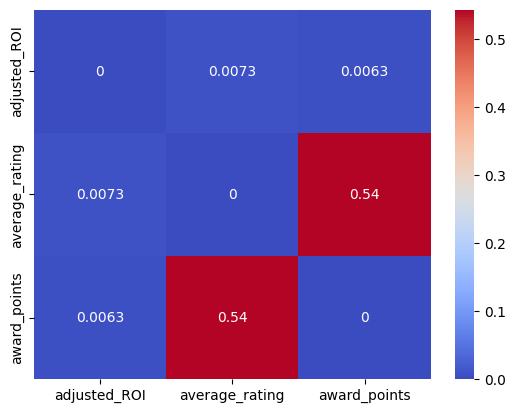

('average_rating', 'award_points')


In [28]:
corr_matrix = df[[ "adjusted_ROI", 'average_rating', 
                             "award_points"]].corr()

# Compute the correlation matrix
for i in range(corr_matrix.shape[0]):
    corr_matrix.iloc[i, i] = 0

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.show()

max_corr_value = corr_matrix.abs().max().max()
result = corr_matrix.where(corr_matrix == max_corr_value).stack().index.tolist()[0]

print(result)
# !TODO: write about connection between labels that we should use model that catch this correlation

The correlation number between 'average_rating' and 'award_points' shows that there is a somewhat strong link between the average rating of a movie and the award points it gets. Basically, if a movie has a higher rating, it's somewhat more likely to have more award points too. This makes sense because good movies are often liked by viewers and also get awards.

But, a 0.55 number isn't super strong, so there are probably other things affecting award points that we're not seeing here. And just because two things are linked doesn't mean one causes the other.

there's pretty much no relationship between a movie's Return on Investment (ROI) and its average rating or award points. In other words, just because a movie makes more money (has a higher ROI), it doesn’t mean people will rate it higher or that it will win more awards. And vice versa, a well-rated movie or a movie with lots of awards doesn’t necessarily make more money.

The idea here is that a movie can be successful in many ways - it could make a lot of money, people could love it, or it could win a lot of awards. Our numbers are helping us see these different kinds of success and how they relate to each other.

Let's find the most successful movies in each category:

In [29]:
# Top 10 movies by adjusted_ROI
top10_ROI = df.nlargest(10, 'adjusted_ROI')

# Top 10 movies by average_rating
top10_rating = df.nlargest(10, 'average_rating')

# Top 10 movies by award_points
top10_awards_won = df.nlargest(10, 'award_points')

# To display the top 10 lists
print("Top 10 movies by ROI metric:")
print(top10_ROI[['title', 'adjusted_ROI']])

print("\nTop 10 movies by rating matric:")
print(top10_rating[['title', 'average_rating']])

print("\nTop 10 movies by award metric:")
print(top10_awards_won[['title', 'award_points']])


Top 10 movies by ROI metric:
                        title  adjusted_ROI
6845                    saved     499900.00
2099  the blair witch project     414298.50
4686              deep throat     399900.00
1937         1 night in paris     178631.01
5604              smithereens     100789.25
2823               angel town      99994.74
3393           american adobo      99567.15
5325      paranormal activity      89832.93
2607        lady frankenstein      69741.50
1961    aloha, bobby and rose      58233.33

Top 10 movies by rating matric:
                                              title  average_rating
4852                       the shawshank redemption           88.98
4827                                  the godfather           88.16
6492                                the dark knight           86.72
6474  the lord of the rings: the return of the king           86.21
4115                               schindler's list           86.18
4829                          the godfather pa

In [30]:
# Anti Top 10 movies by adjusted_ROI
top10_ROI = df.nsmallest(10, 'adjusted_ROI')

# Anti Top 10 movies by average_rating
top10_rating = df.nsmallest(10, 'average_rating')

# To display the top 10 lists
print("Anti Top 10 movies by ROI metric:")
print(top10_ROI[['title', 'adjusted_ROI']])

print("\n Anti Top 10 movies by rating matric:")
print(top10_rating[['title', 'average_rating']])


Anti Top 10 movies by ROI metric:
                                           title  adjusted_ROI
6339                                  trojan war       -100.00
1569                               cross of iron       -100.00
6709                                   java heat        -99.99
6955                               a perfect man        -99.99
1950                               the point men        -99.99
5949                               the samaritan        -99.98
715     the goalie's anxiety at the penalty kick        -99.98
6940  the adventurer: the curse of the midas box        -99.97
925                                walk on water        -99.97
6565                             the guillotines        -99.96

 Anti Top 10 movies by rating matric:
                     title  average_rating
4221  dragonball evolution           43.90
4187        disaster movie           45.05
5126            epic movie           45.87
4112        batman & robin           45.92
5746     meet the s

### Features

#### Collection

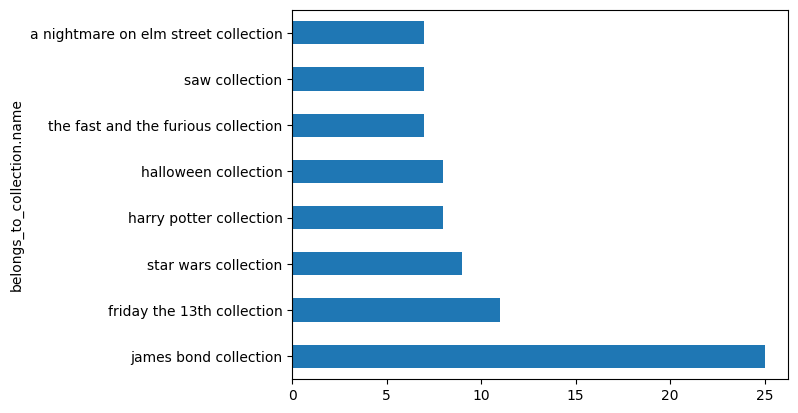

In [31]:
df['belongs_to_collection.name'].value_counts()
df['belongs_to_collection.name'].value_counts().head(8).plot(kind='barh')
import matplotlib.pyplot as plt
plt.show()

df['collection'] = df['belongs_to_collection.name'].notna()

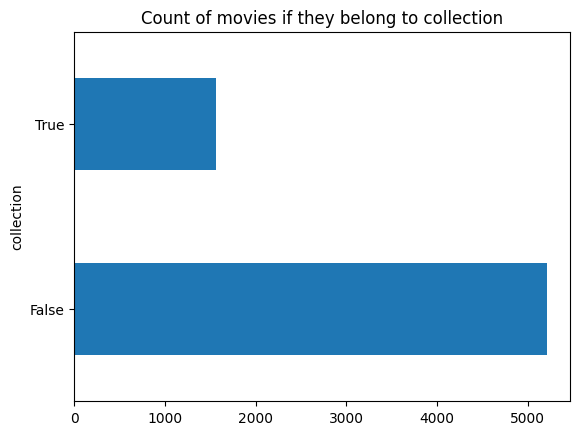

In [32]:
df['collection'].value_counts()
df['collection'].value_counts().plot(kind='barh')
plt.title('Count of movies if they belong to collection')

plt.show()

#### Runtime

/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


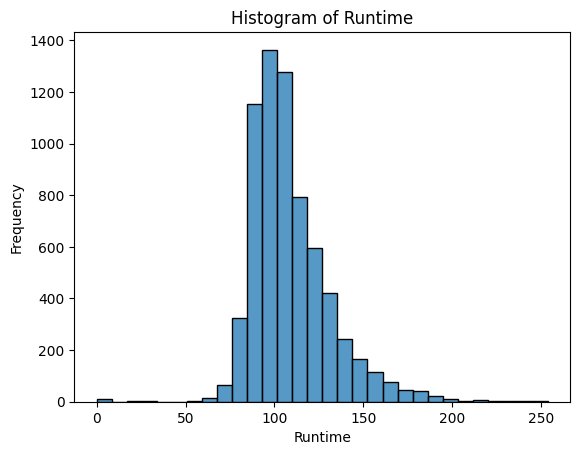

In [33]:
import seaborn as sns

sns.histplot(df['runtime'], bins=30, kde=False)  # You can change the number of bins as needed
plt.xlabel('Runtime')
plt.ylabel('Frequency')
plt.title('Histogram of Runtime')
plt.show()

#### Original language

The most popular movie original language in the dataset is english.

The ratio of English to non-English movies is: 82.74%


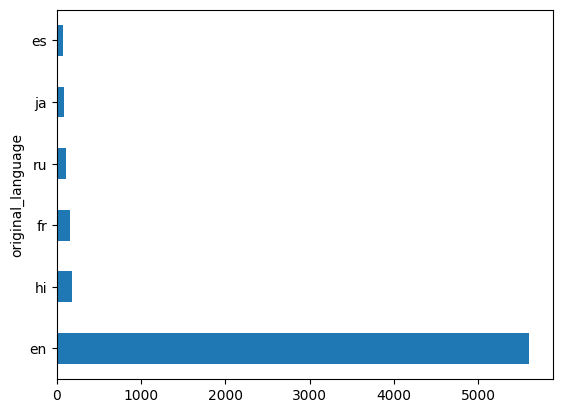

In [34]:
english_others_ratio = (len(df[df['original_language'] =='en']) / len(df)) * 100
print(f"The ratio of English to non-English movies is: {english_others_ratio:.2f}%")

df['original_language'].value_counts().head(6).plot(kind='barh')
plt.show()

Let's compare success metrics for non-english and english movies

In [35]:
df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
grouped = df.groupby('is_english')
print("median", grouped[['adjusted_ROI', 'average_rating', 'award_points']].median())
grouped[['adjusted_ROI', 'average_rating', 'award_points']].describe()

median             adjusted_ROI  average_rating  award_points
is_english                                            
0                  58.63           63.41          9.00
1                  86.85           63.37          8.00


adjusted_ROI                                                        \
                  count   mean      std     min    25%   50%    75%       max   
is_english                                                                      
0               1168.00 631.65  4982.51  -99.98 -41.66 58.63 283.76 100789.25   
1               5601.00 691.86 10777.79 -100.00 -33.00 86.85 289.72 499900.00   

           average_rating        ...             award_points              \
                    count  mean  ...   75%   max        count  mean   std   
is_english                       ...                                        
0                 1168.00 64.62  ... 64.62 83.74      1168.00 31.42 56.82   
1                 5601.00 64.55  ... 65.77 88.98      5601.00 28.05 66.00   

                                         
            min  25%  50%   75%     max  
is_english                               
0          0.00 1.00 9.00 35.00  700.00  
1          0.00 2.00 8.00 25.00 1069.00  

[2 rows x 24 columns]

**ROI**

Both English and non-English movies have a wide range of ROI values, as evidenced by the large standard deviations and the vast difference between the minimum and maximum values. The median ROI is higher for English movies compared to non-English movies, suggesting that the typical English movie has a higher ROI.

**Average Rating**

Non-English movies have a slightly higher mean and median rating compared to English movies. The range of ratings is broader for English movies. The median rating is also higher for non-English movies, indicating that non-English movies tend to receive slightly higher ratings on average.

**Award Points**

Non-English movies are associated with a bit higher mean and median number of award points, indicating a possible higher level of award recognition for non-English movies in this dataset.

#### Title, overview, tagline and plot

For those features I'm going to use TfidfVectorizer with decomposition and sentiment analysis:

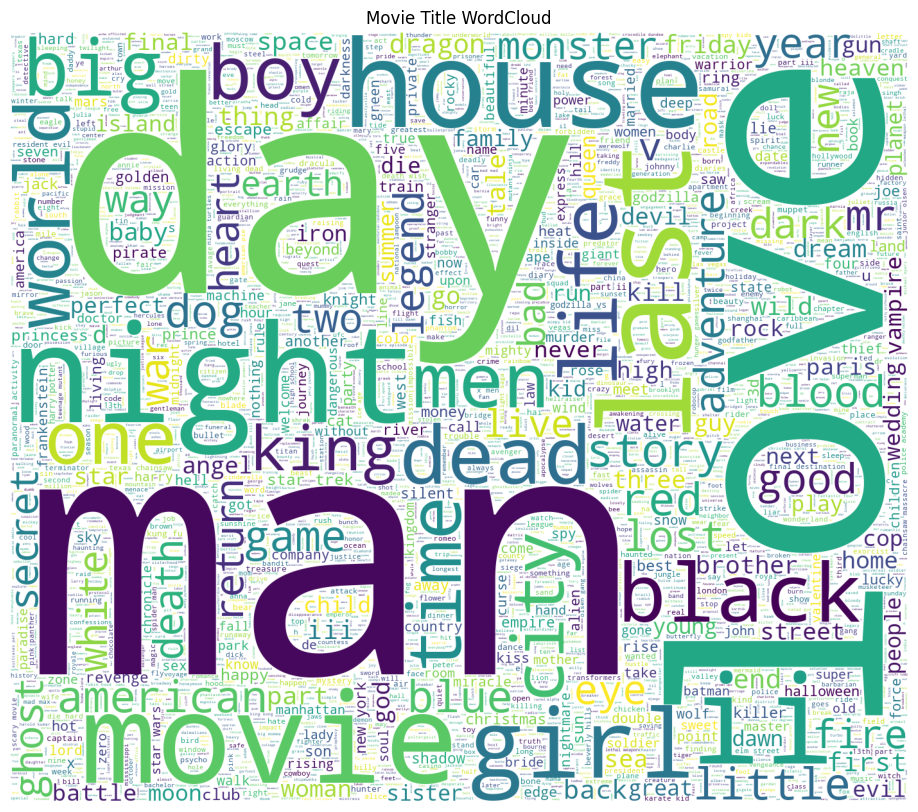

In [36]:
#!TODO: frequent words, word clouds, etc

text = ' '.join(df['title'].astype(str))
plt.subplots(figsize=(16,10))
wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          max_words=10000,
                          width=1400,
                          height=1200
                         ).generate(text)


plt.imshow(wordcloud)
plt.title('Movie Title WordCloud')
plt.axis('off')
plt.show()

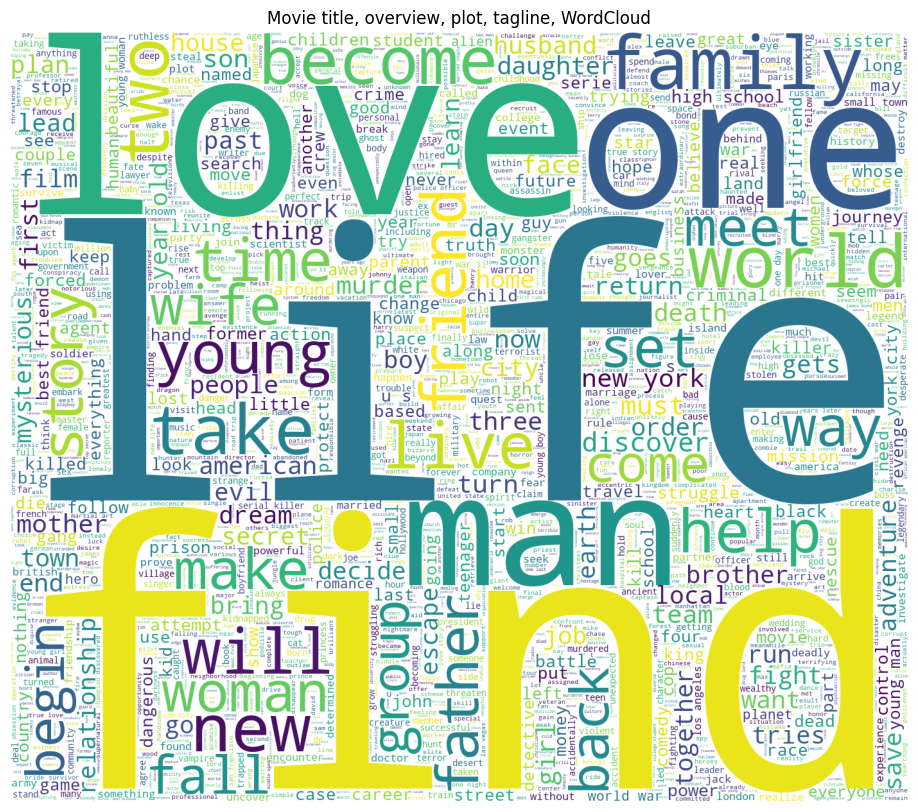

In [37]:
text_columns = ['title', 'overview', 'plot', 'tagline']
text_data= df[text_columns].apply(lambda x: ' '.join(x), axis=1) 

text = ' '.join(text_data.astype(str))
plt.subplots(figsize=(16,10))
wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          max_words=10000,
                          width=1400,
                          height=1200
                         ).generate(text)


plt.imshow(wordcloud)
plt.title('Movie title, overview, plot, tagline, WordCloud')
plt.axis('off')
plt.show()

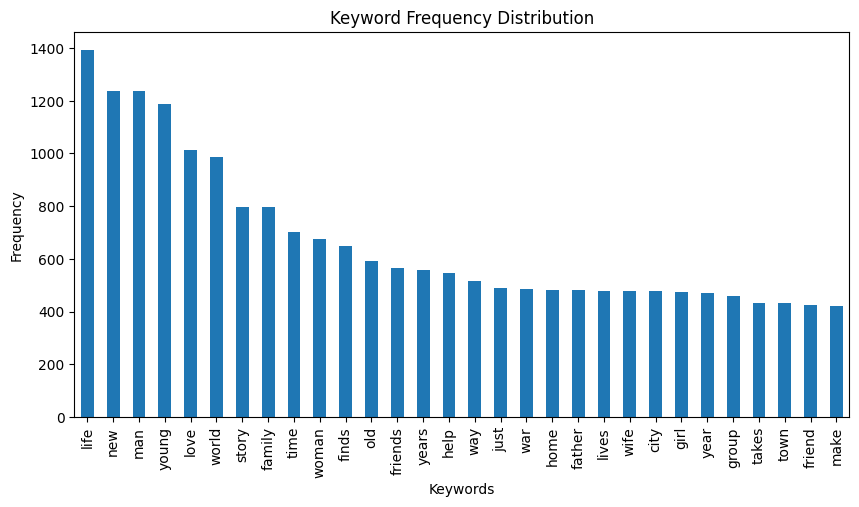

In [38]:

vectorizer = TfidfVectorizer(max_features=300, stop_words='english')  # Create a TF-IDF vectorizer, extracting top 100 keywords
tfidf_matrix = vectorizer.fit_transform(text_data)  # Fit and transform the text data

keywords = vectorizer.get_feature_names_out()  # Get the keywords
binary_features = (tfidf_matrix > 0).astype(int)  # Convert TF-IDF values to binary values (1 if TF-IDF value > 0, else 0)

binary_features_df = pd.DataFrame(binary_features.toarray(), columns=keywords)  # Convert to DataFrame
keyword_frequencies = binary_features_df.sum(axis=0)  # Sum each column to get keyword frequencies

# Plotting
keyword_frequencies.sort_values(ascending=False).head(30).plot(kind='bar', figsize=(10, 5))
plt.title('Keyword Frequency Distribution')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.show()

svd = TruncatedSVD(n_components=1)
# Reduce dimensionality
reduced_tfidf_matrix = svd.fit_transform(tfidf_matrix)
df['text'] = reduced_tfidf_matrix

Stopwords are common words that are often filtered out in the preprocessing step in text analysis to reduce dimensionality and noise. However, they can sometimes carry sentiment (e.g., "not" in "not good"). Removing stopwords can potentially alter the original sentiment of the text. TextBlob library you are using in your code snippet does not require explicit stopword removal as

In [39]:
from textblob import TextBlob
df['overview_sentiment'] = df['overview'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['title_sentiment'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['tagline_sentiment'] = df['tagline'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['plot_sentiment'] = df['plot'].apply(lambda x: TextBlob(x).sentiment.polarity)

df = df.drop(['overview', 'tagline', 'plot'], axis=1)

#### Year/month

/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages

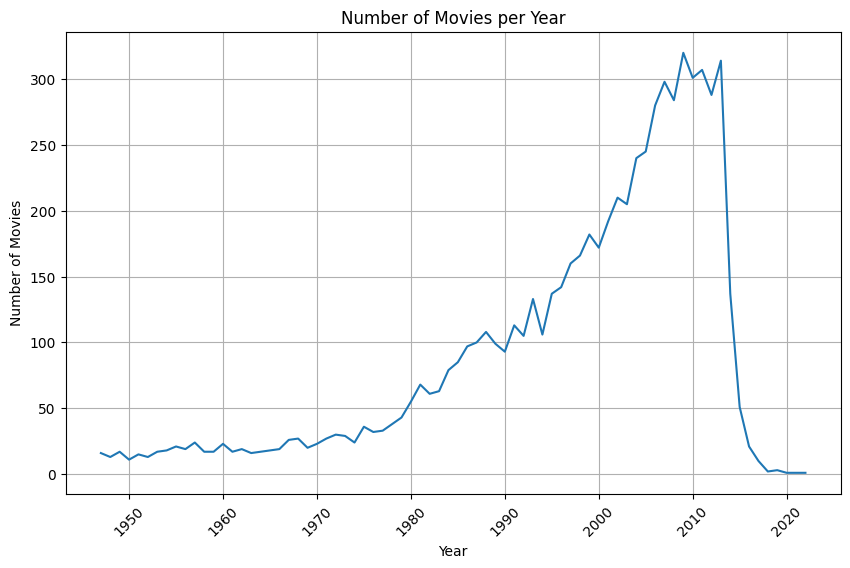

In [40]:
# Get the count of movies per year
movies_per_year = df['release_year'].value_counts().sort_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=movies_per_year)
plt.title('Number of Movies per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)  
plt.grid(True)
plt.show()

In our dataset, each movie has a release year associated with it. However, looking at individual years can be a bit overwhelming, and might not provide a clear picture of trends over time. This is because the movie industry has evolved over decades, and the circumstances surrounding movie production, distribution, and reception can vary greatly from one decade to another.

To make our analysis more insightful and easier to interpret, we've created a new column named era. This column categorizes movies into distinct time periods, specifically decades, such as '1940-1950', '1950-1960', and so on. By doing this, we aim to simplify our dataset and potentially uncover trends or patterns that occur over these broader time periods rather than on a year-by-year basis.

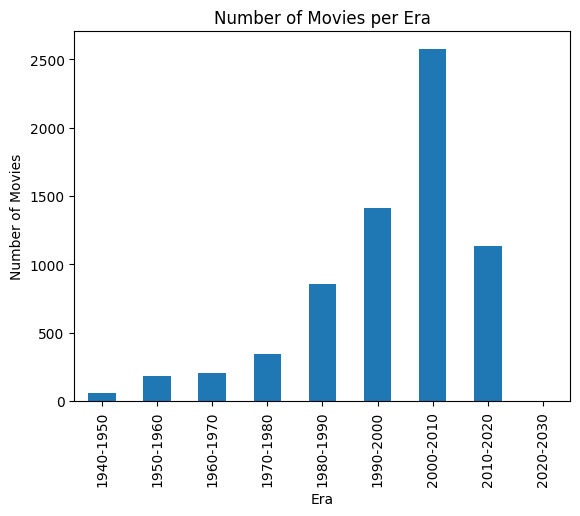

In [41]:
bins = [1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
labels = ['1940-1950', '1950-1960', '1960-1970', '1970-1980', '1980-1990','1990-2000', '2000-2010', '2010-2020', '2020-2030']

df['era'] = pd.cut(df['release_year'], bins=bins, labels=labels, include_lowest=True)

era_counts = df['era'].value_counts().sort_index()

era_counts.plot(kind='bar')

plt.title('Number of Movies per Era')
plt.xlabel('Era')
plt.ylabel('Number of Movies')

plt.show()


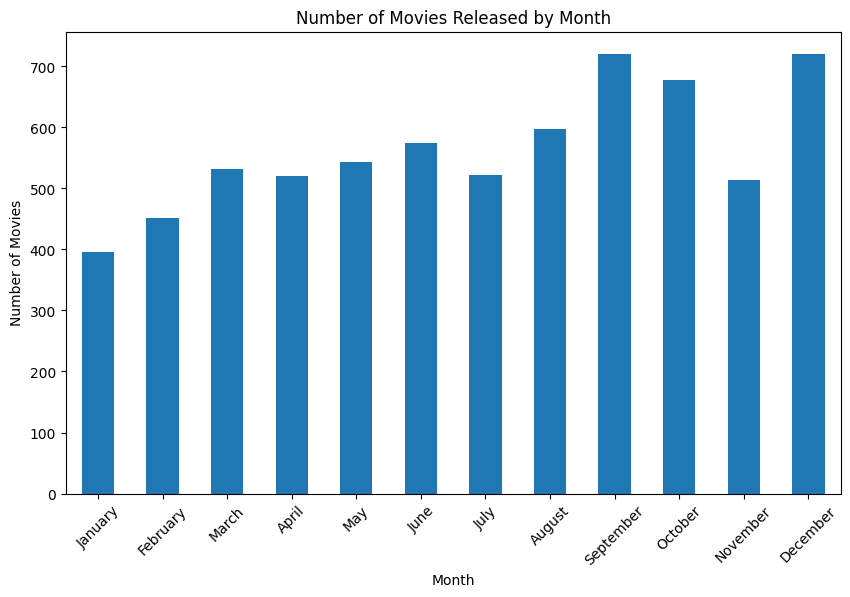

In [42]:
month_counts = df['release_month'].value_counts().sort_index()
month_counts.plot(kind='bar', figsize=(10,6))

plt.title('Number of Movies Released by Month')
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.xticks(ticks=range(12), labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=45)
plt.show()

In [43]:
df.columns

Index(['title', 'release_year', 'release_month', 'original_language',
       'spoken_languages', 'genres', 'production_companies',
       'production_countries', 'runtime', 'rated', 'tmdb_popularity', 'cast',
       'crew', 'belongs_to_collection.name', 'adjusted_ROI',
       'numerical_ROI_category', 'average_rating', 'numerical_rating_category',
       'award_points', 'numerical_award_category', 'collection', 'is_english',
       'text', 'overview_sentiment', 'title_sentiment', 'tagline_sentiment',
       'plot_sentiment', 'era'],
      dtype='object')

/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_

<Axes: title={'center': 'Awards points by the Month for hit award_points'}, xlabel='mon', ylabel='award_points'>

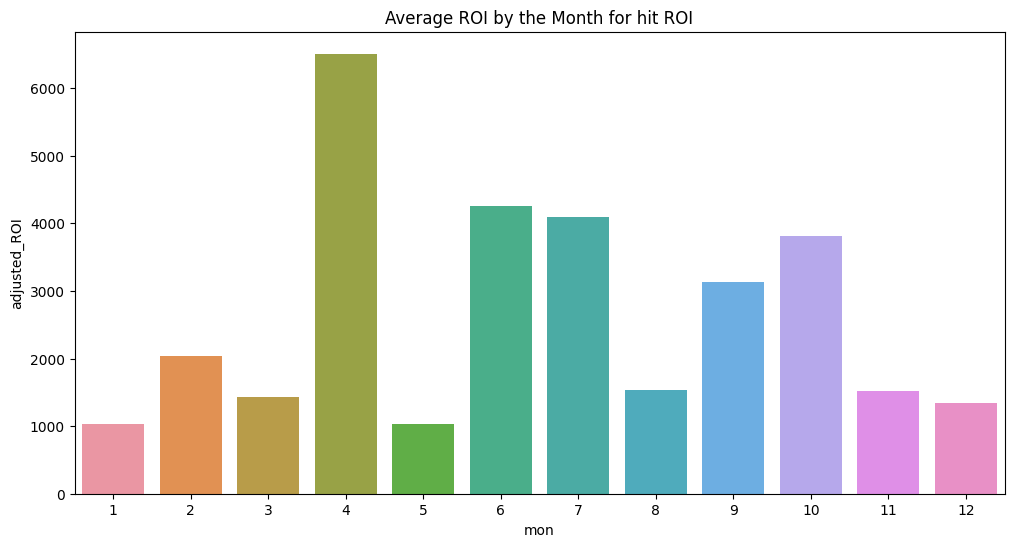

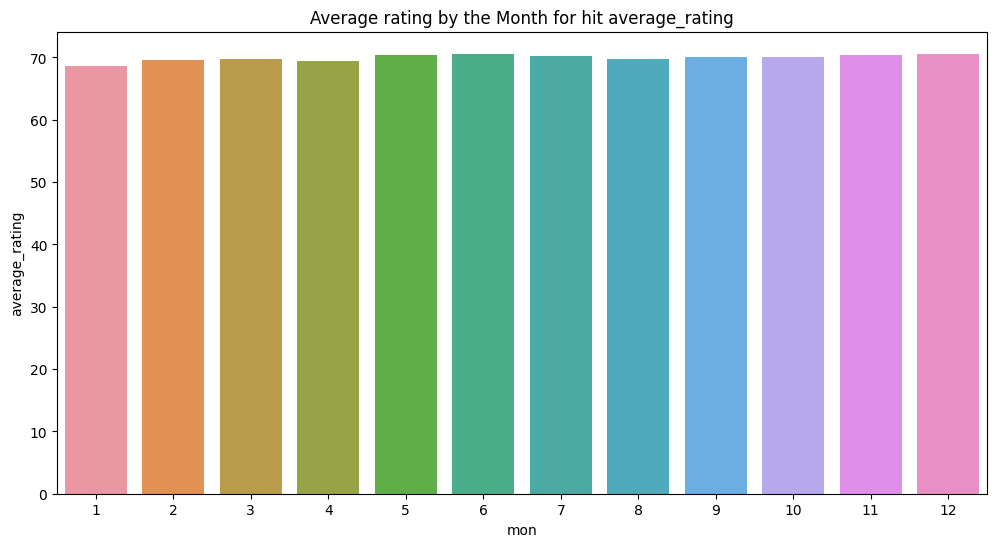

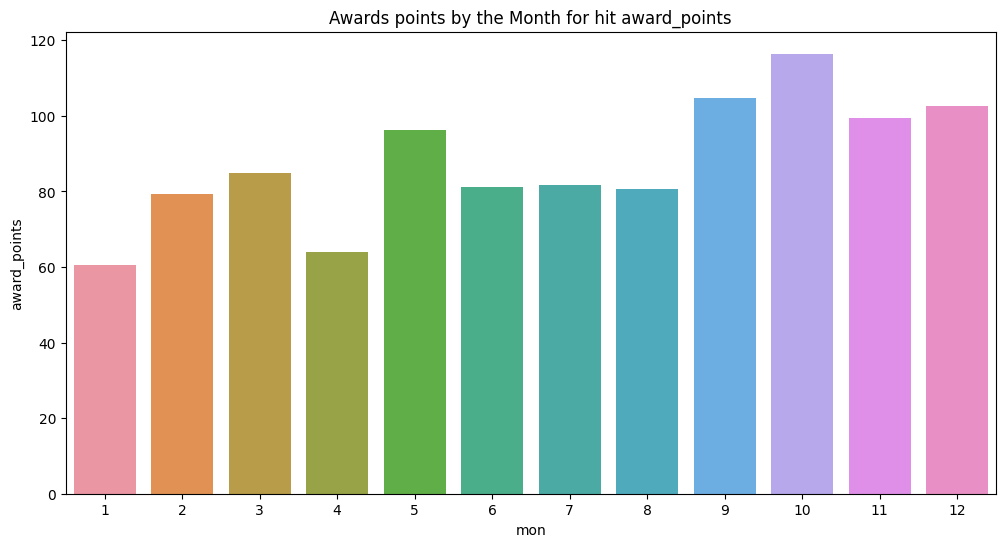

In [44]:
month_mean_hit = pd.DataFrame(df[df['numerical_ROI_category'] == 1].groupby('release_month')['adjusted_ROI'].mean())
month_mean_hit['mon'] = month_mean_hit.index
plt.figure(figsize=(12,6))
plt.title("Average ROI by the Month for hit ROI")
sns.barplot(x='mon', y='adjusted_ROI', data=month_mean_hit)

month_mean_hit = pd.DataFrame(df[df['numerical_rating_category'] == 1].groupby('release_month')['average_rating'].mean())
month_mean_hit['mon'] = month_mean_hit.index
plt.figure(figsize=(12,6))
plt.title("Average rating by the Month for hit average_rating")
sns.barplot(x='mon', y='average_rating', data=month_mean_hit)

month_mean_hit = pd.DataFrame(df[df['numerical_award_category'] == 1].groupby('release_month')['award_points'].mean())
month_mean_hit['mon'] = month_mean_hit.index
plt.figure(figsize=(12,6))
plt.title("Awards points by the Month for hit award_points")
sns.barplot(x='mon', y='award_points', data=month_mean_hit)

We observe a trend of higher ROI during the summer. A notable number of awarded movies were released in September and October, aligning with the typical release period for Oscar-nominated movies as per The Ringer (https://www.theringer.com/oscars/2018/2/28/17060396/best-oscar-movie-release-date). The analysis shows a shift in the ideal release date to October and November, with these months hosting 60.4% of Big Four winners since 2005, compared to only 25% from 1986 through 2005. Interestingly, the release month doesn't seem to affect the average rating of the movies

In [45]:
df['is_summer'] = df['release_month'].apply(lambda x: 1 if x in ['6', '7'] else 0)
df['is_autumn'] = df['release_month'].apply(lambda x: 1 if x in ['9', '10', '11'] else 0)

#### Genres

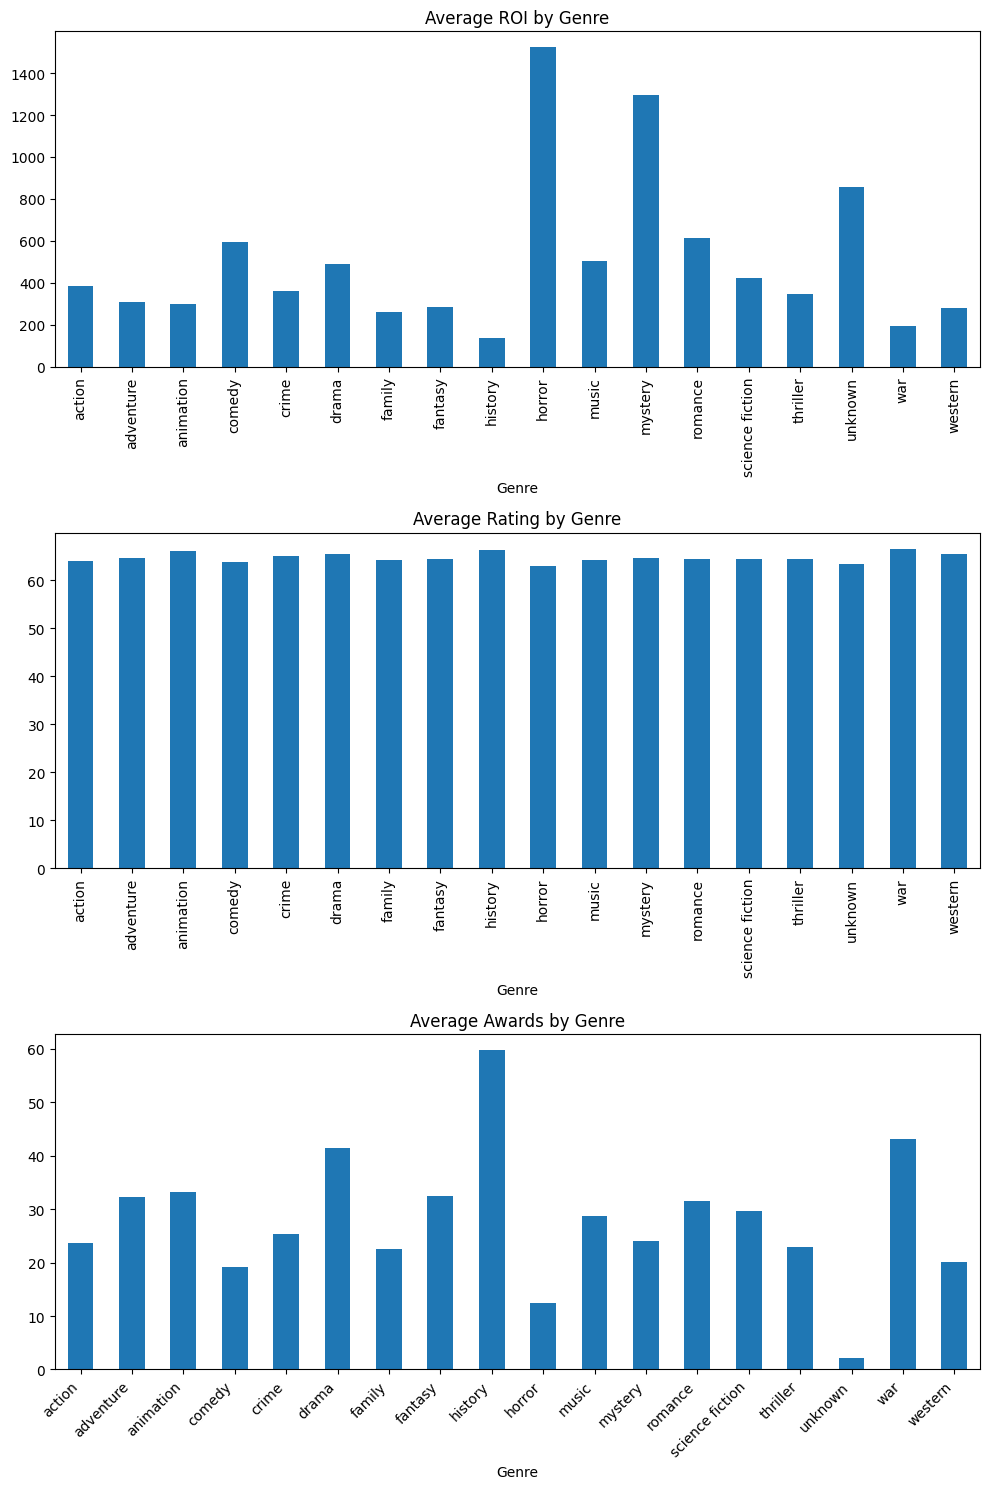

In [46]:
df['genres_list'] = df['genres'].str.split(',')

genres_dict = {'ROI': [], 'Rating': [], 'Awards': [], 'Genre': []}

for index, row in df.iterrows():
    for genre in row['genres_list']:
        genres_dict['Genre'].append(genre)
        genres_dict['ROI'].append(row['adjusted_ROI'])
        genres_dict['Rating'].append(row['average_rating'])
        genres_dict['Awards'].append(row['award_points'])

genres_df = pd.DataFrame(genres_dict)

genre_means = genres_df.groupby('Genre').mean()

fig, axs = plt.subplots(3, figsize=(10,15))

genre_means['ROI'].plot(kind='bar', ax=axs[0], title='Average ROI by Genre')
genre_means['Rating'].plot(kind='bar', ax=axs[1], title='Average Rating by Genre')
genre_means['Awards'].plot(kind='bar', ax=axs[2], title='Average Awards by Genre')

plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()


Based on the analysis, it's evident that genres do impact the movie's performance in different metrics. Specifically, horror and mystery genres tend to yield higher average ROI, indicating they might be more profitable. On the other hand, the average rating remains consistent across all genres, suggesting that genre doesn't significantly affect the audience's perceived quality. However, when it comes to awards, history, war, and drama genres are more likely to receive recognition, likely due to their often profound and thought-provoking narratives. 

Let's overview genres in our hit movies:

In [47]:
df.columns

Index(['title', 'release_year', 'release_month', 'original_language',
       'spoken_languages', 'genres', 'production_companies',
       'production_countries', 'runtime', 'rated', 'tmdb_popularity', 'cast',
       'crew', 'belongs_to_collection.name', 'adjusted_ROI',
       'numerical_ROI_category', 'average_rating', 'numerical_rating_category',
       'award_points', 'numerical_award_category', 'collection', 'is_english',
       'text', 'overview_sentiment', 'title_sentiment', 'tagline_sentiment',
       'plot_sentiment', 'era', 'is_summer', 'is_autumn', 'genres_list'],
      dtype='object')

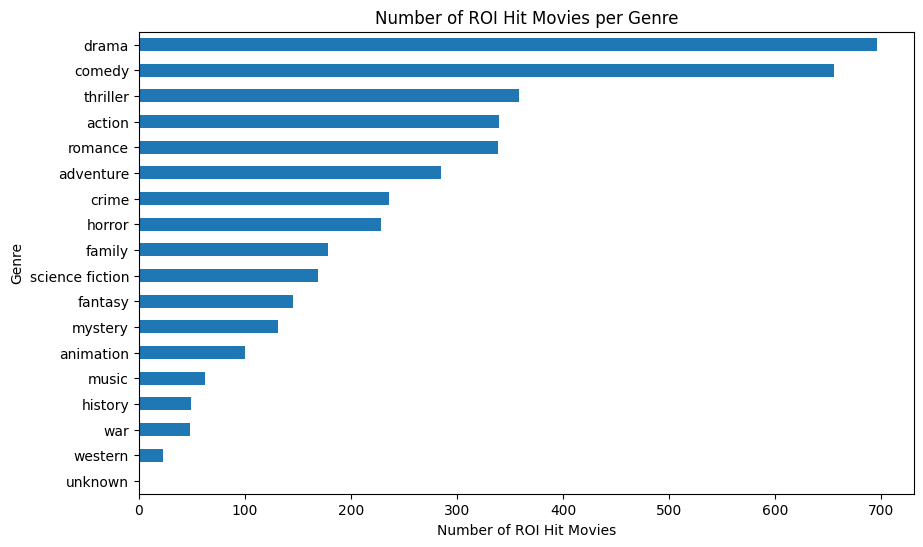

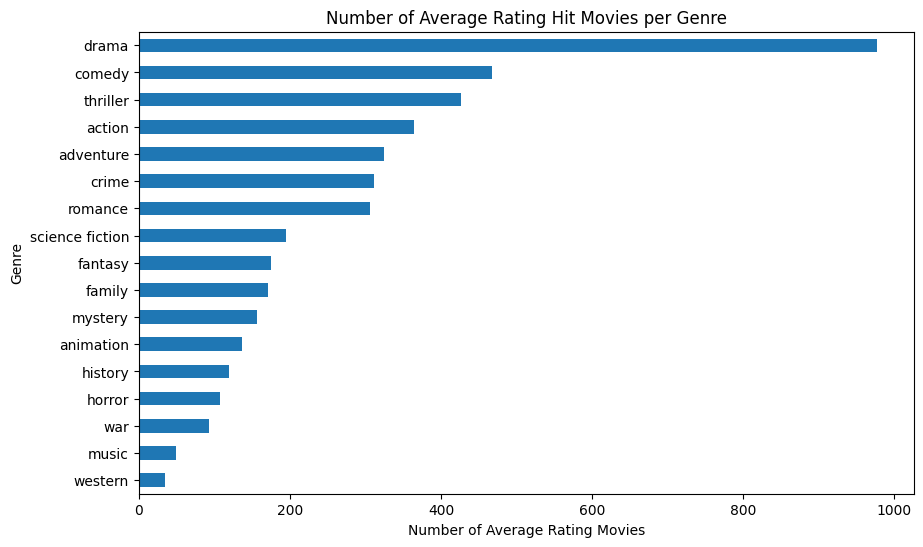

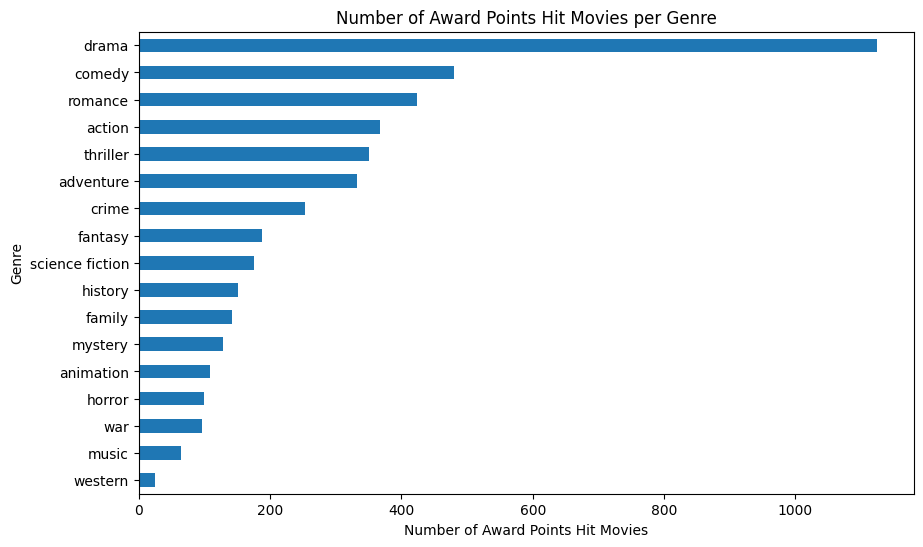

In [48]:
genres_expanded = df.explode('genres_list')

hit_movies_ROI = genres_expanded[genres_expanded['numerical_ROI_category'] == 1]
hit_movies_count_ROI = hit_movies_ROI['genres_list'].value_counts()

hit_movies_count_ROI.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Number of ROI Hit Movies per Genre')
plt.xlabel('Number of ROI Hit Movies')
plt.ylabel('Genre')
plt.show()

hit_movies_rating = genres_expanded[genres_expanded['numerical_rating_category'] == 1]
hit_movies_count_rating = hit_movies_rating['genres_list'].value_counts()

hit_movies_count_rating.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Number of Average Rating Hit Movies per Genre')
plt.xlabel('Number of Average Rating Movies')
plt.ylabel('Genre')
plt.show()

hit_movies_award = genres_expanded[genres_expanded['numerical_award_category'] == 1]
hit_movies_count_award = hit_movies_award['genres_list'].value_counts()

hit_movies_count_award.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Number of Award Points Hit Movies per Genre')
plt.xlabel('Number of Award Points Hit Movies')
plt.ylabel('Genre')
plt.show()




As observed, drama, comedy, and romance emerge as the most prevalent genres across each metric. Let's create dummies from this column

In [49]:
genre_dummies = df['genres'].str.get_dummies(sep=',')
df = pd.concat([df, genre_dummies], axis=1)
df

title  release_year  release_month  \
0            the pit and the pendulum          1961              8   
1     universal soldier: regeneration          2009             10   
2                         the heiress          1949             10   
4                     problem child 2          1991              7   
5                                fame          2009              9   
...                               ...           ...            ...   
7082              18 & 1/2 cigarettes          2011              4   
7083             sunset at chaophraya          2013              4   
7084                          what if          2013              9   
7085                   make your move          2013              8   
7086                             chef          2014              5   

     original_language spoken_languages  \
0                   en               en   
1                   en            bg,en   
2                   en               en   
4                   en            es,en   
5                   en               en   
...                ...              ...   
7082                es               es   
7083                th         en,ja,th   
7084                en               en   
7085                en               en   
7086                en            en,es   

                                         genres  \
0                                horror,mystery   
1     adventure,action,science fiction,thriller   
2                         drama,romance,history   
4                                 comedy,family   
5                    music,comedy,drama,romance   
...                                         ...   
7082                                      drama   
7083                          drama,romance,war   
7084                       drama,comedy,romance   
7085                                      music   
7086                                     comedy   

                                   production_companies production_countries  \
0     alta vista productions,american international ...                   us   
1     foresight unlimited,signature entertainment,ba...                   us   
2                                             paramount                   us   
4              imagine entertainment,universal pictures                   us   
5     united artists,lakeshore entertainment,metro-g...                   us   
...                                                 ...                  ...   
7082        canana,zelig cinematografica,tornasol films             mx,py,es   
7083                                                m39                   th   
7084  fastnet films,no trace camping,caramel films,c...             ca,ie,us   
7085  serendipity productions,cj entertainment,sm en...                kr,us   
7086      altus media,fairview entertainment,prescience                   us   

      runtime    rated  ...  history horror music mystery  romance  \
0          81  unrated  ...        0      1     0       1        0   
1          97        r  ...        0      0     0       0        0   
2         115  unrated  ...        1      0     0       0        1   
4          90    pg-13  ...        0      0     0       0        0   
5         107       pg  ...        0      0     1       0        1   
...       ...      ...  ...      ...    ...   ...     ...      ...   
7082       71  unrated  ...        0      0     0       0        0   
7083      125  unrated  ...        0      0     0       0        1   
7084       93    pg-13  ...        0      0     0       0        1   
7085      110    pg-13  ...        0      0     1       0        0   
7086      114        r  ...        0      0     0       0        0   

      science fiction  thriller  unknown  war  western  
0                   0         0        0    0        0  
1                   1         1        0    0        0  
2                   0         0        0    0        0  
4                   0         0

#### Rated

/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_

<Axes: title={'center': 'Awards points by the MPA Rating for hit award_points'}, xlabel='rated', ylabel='award_points'>

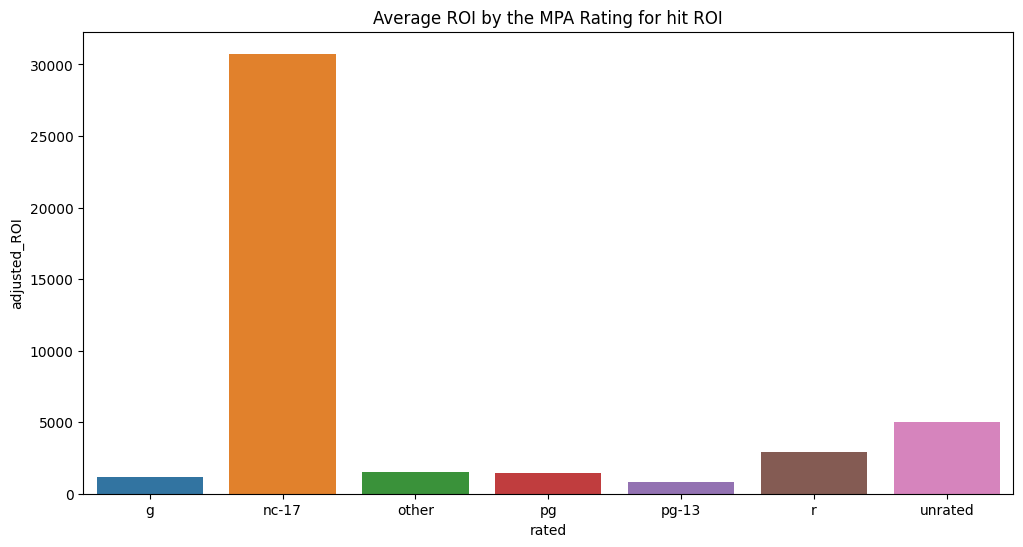

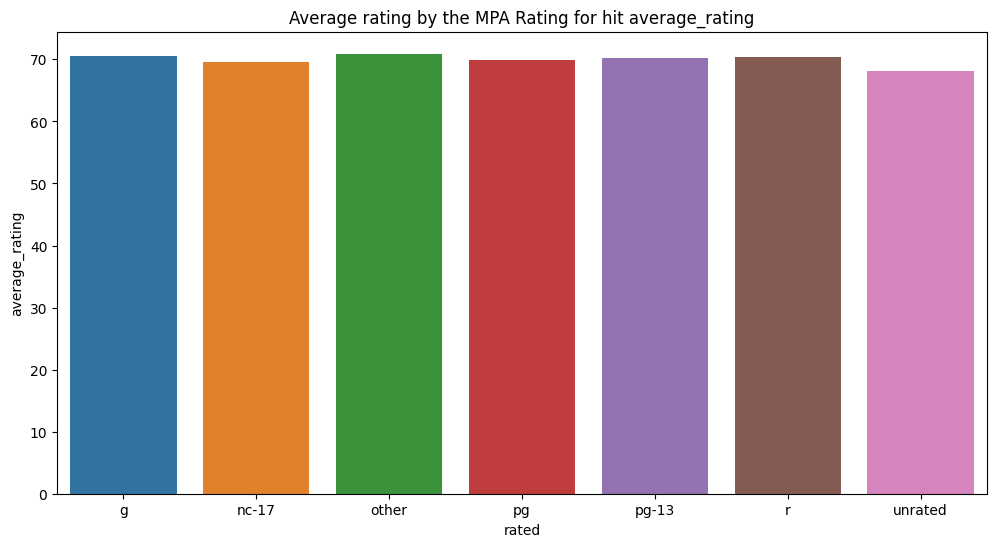

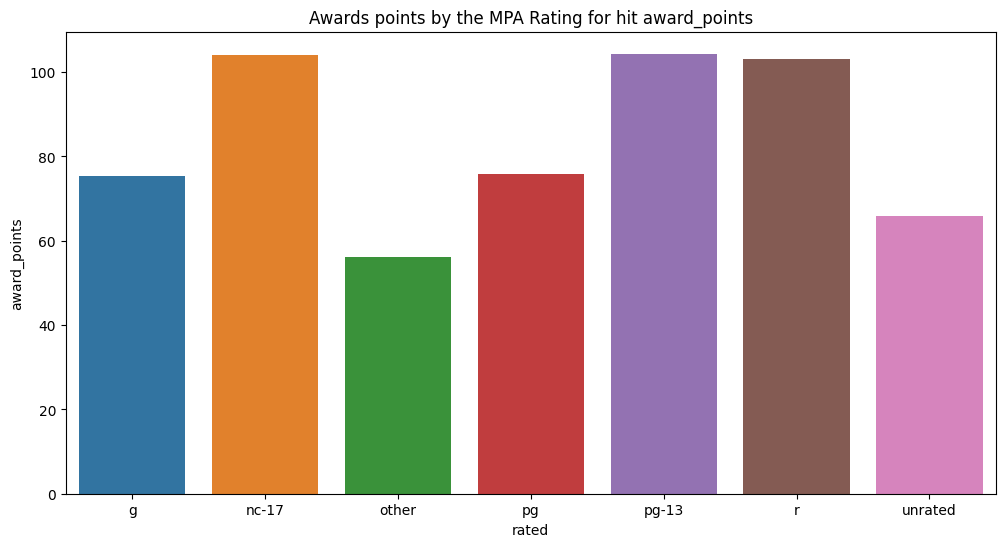

In [50]:
rated_mean_hit = pd.DataFrame(df[df['numerical_ROI_category'] == 1].groupby('rated')['adjusted_ROI'].mean())
rated_mean_hit['rated'] = rated_mean_hit.index
plt.figure(figsize=(12,6))
plt.title("Average ROI by the MPA Rating for hit ROI")
sns.barplot(x='rated', y='adjusted_ROI', data=rated_mean_hit)

rated_mean_hit = pd.DataFrame(df[df['numerical_rating_category'] == 1].groupby('rated')['average_rating'].mean())
rated_mean_hit['rated'] = rated_mean_hit.index
plt.figure(figsize=(12,6))
plt.title("Average rating by the MPA Rating for hit average_rating")
sns.barplot(x='rated', y='average_rating', data=rated_mean_hit)

rated_mean_hit = pd.DataFrame(df[df['numerical_award_category'] == 1].groupby('rated')['award_points'].mean())
rated_mean_hit['rated'] = rated_mean_hit.index
plt.figure(figsize=(12,6))
plt.title("Awards points by the MPA Rating for hit award_points")
sns.barplot(x='rated', y='award_points', data=rated_mean_hit)

Movies rated NC-17 make more money on average, but they don't get better ratings. On the other hand, movies rated R and PG-13 get more awards. So, while NC-17 movies might be good for making money, R and PG-13 movies are better if you're looking for awards.



#### List colums: spoken_languages, genres, production_companies, production_countries



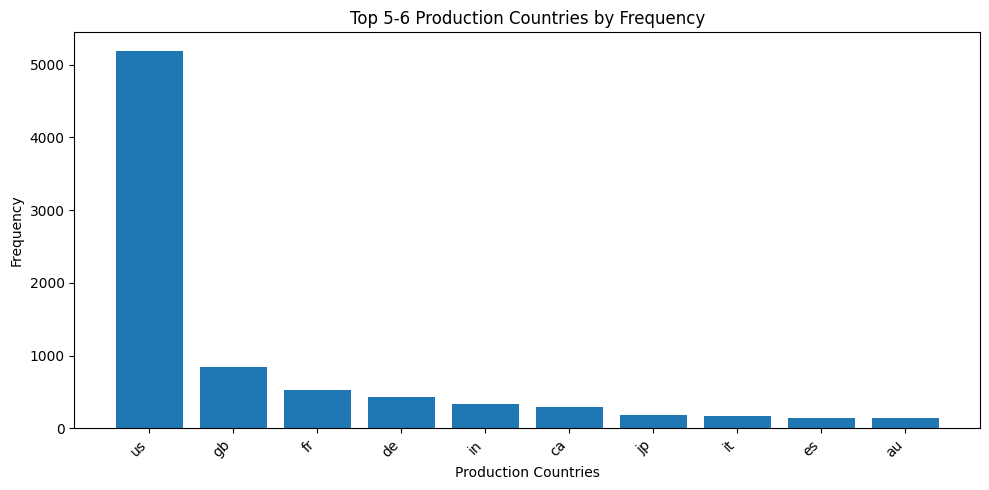

In [51]:
production_c_df = df.copy()
production_c_df['production_countries'] = production_c_df['production_countries'].str.split(',')
genre_counter = Counter(genre for genre_list in production_c_df['production_countries'].dropna() for genre in genre_list)
genre_frequencies = pd.DataFrame(genre_counter.items(), columns=['production_countries', 'frequency'])

genre_frequencies = genre_frequencies.sort_values(by='frequency', ascending=False).reset_index(drop=True)
genre_frequencies

top_countries = genre_frequencies.head(10)


plt.figure(figsize=(10, 5))
plt.bar(top_countries['production_countries'], top_countries['frequency'])
plt.xlabel('Production Countries')
plt.ylabel('Frequency')
plt.title('Top 5-6 Production Countries by Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()

The majority of movies in the dataset are produced in the US

In [52]:
empty_strings = df['production_companies'].value_counts().get('', 0)
print(f"Number of empty strings in column_name: {empty_strings}")

df['production_companies'] = df['production_companies'].replace('', 'no_company')


Number of empty strings in column_name: 0


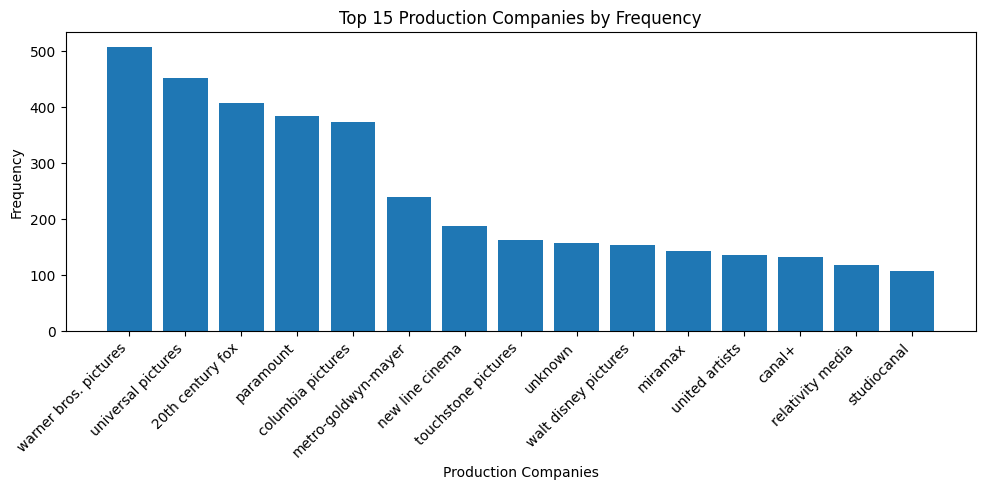

In [53]:
production_c_df = df.copy()
production_c_df['production_companies'] = production_c_df['production_companies'].str.split(',')
genre_counter = Counter(genre for genre_list in production_c_df['production_companies'].dropna() for genre in genre_list)
production_companies = pd.DataFrame(genre_counter.items(), columns=['production_companies', 'frequency'])

production_companies = production_companies.sort_values(by='frequency', ascending=False).reset_index(drop=True)
production_companies.head(10)

top_companies= production_companies.head(15)

# Create a bar graph
plt.figure(figsize=(10, 5))
plt.bar(top_companies['production_companies'], top_companies['frequency'])
plt.xlabel('Production Companies')
plt.ylabel('Frequency')
plt.title('Top 15 Production Companies by Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()


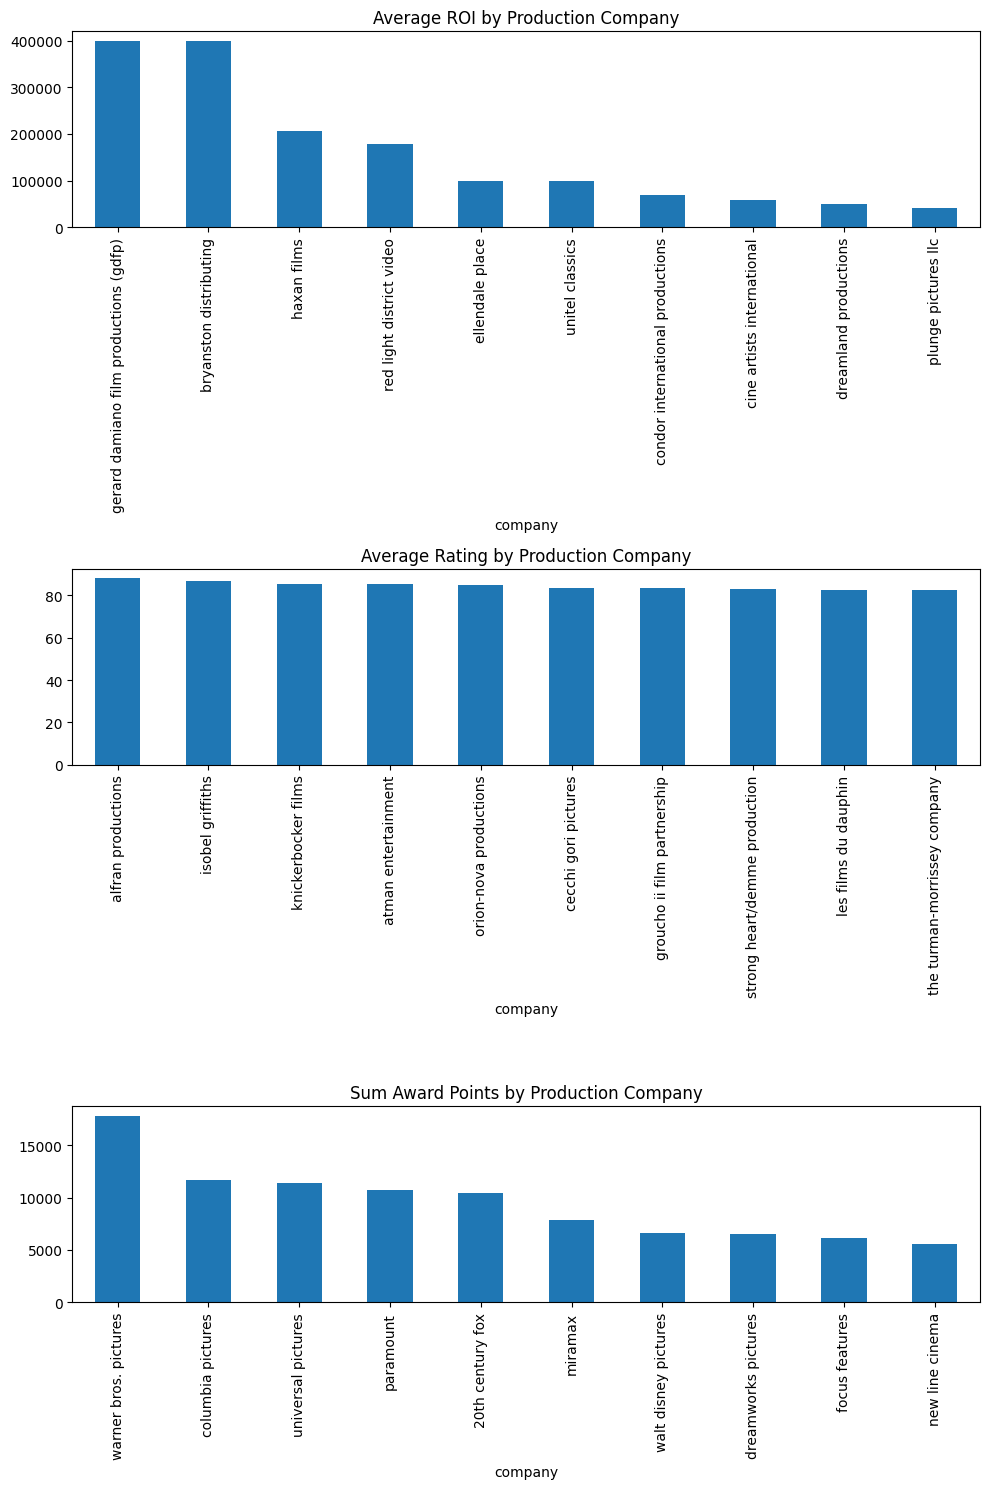

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

companies_expanded = df['production_companies'].str.split(',', expand=True).stack()

roi_values = df.reindex(companies_expanded.index.get_level_values(0))['adjusted_ROI']
rating_values = df.reindex(companies_expanded.index.get_level_values(0))['average_rating']
award_values = df.reindex(companies_expanded.index.get_level_values(0))['award_points']

data = {
    'company': companies_expanded.values,
    'adjusted_ROI': roi_values.values,
    'average_rating': rating_values.values,
    'award_points': award_values.values
}
company_df = pd.DataFrame(data)

company_aggregations = company_df.groupby('company').agg({
    'award_points': 'sum',
    'adjusted_ROI': 'mean',
    'average_rating': 'mean'
})

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
sorted_companies = company_aggregations.sort_values(by='adjusted_ROI', ascending=False)
sorted_companies['adjusted_ROI'].head(10).plot(kind='bar', ax=ax[0], title='Average ROI by Production Company')
sorted_companies = company_aggregations.sort_values(by='average_rating', ascending=False)
sorted_companies['average_rating'].head(10).plot(kind='bar', ax=ax[1], title='Average Rating by Production Company')
sorted_companies = company_aggregations.sort_values(by='award_points', ascending=False)
sorted_companies['award_points'].head(10).plot(kind='bar', ax=ax[2], title='Sum Award Points by Production Company')
plt.tight_layout()
plt.show()


In [55]:
lang_df = df.copy()
lang_df['spoken_languages'] = lang_df['spoken_languages'].str.split(',')
# Flatten the list of lists and count the occurrences of each country code
genre_counter = Counter(genre for genre_list in lang_df['spoken_languages'].dropna() for genre in genre_list)
# Convert the Counter object to a DataFrame for easier viewing and analysis
genre_frequencies = pd.DataFrame(genre_counter.items(), columns=['spoken_languages', 'frequency'])

genre_frequencies = genre_frequencies.sort_values(by='frequency', ascending=False).reset_index(drop=True)
genre_frequencies.head(10)

spoken_languages  frequency
0               en       5813
1               fr        640
2               es        545
3               de        349
4               it        339
5               ru        326
6               hi        211
7               ja        210
8               zh        154
9               ar        108

And again the majority of movies in the datase uses english as spoken language

Let's compute the count of each item within the list for every row as new features:

In [56]:
df['num_spoken_languages'] = df['spoken_languages'].apply(lambda x: len(x.split(',')) if x else 0)
df['num_genres'] = df['genres'].apply(lambda x: len(x.split(',')) if x else 0)
df['num_production_companies'] = df['production_companies'].apply(lambda x: len(x.split(',')) if x else 0)
df['num_production_countries'] = df['production_countries'].apply(lambda x: len(x.split(',')) if x else 0)
df[['num_spoken_languages', 'num_genres', 'num_production_companies', 'num_production_countries']].describe()

num_spoken_languages  num_genres  num_production_companies  \
count               6769.00     6769.00                   6769.00   
mean                   1.47        2.54                      3.08   
std                    0.91        1.04                      2.24   
min                    1.00        1.00                      1.00   
25%                    1.00        2.00                      2.00   
50%                    1.00        3.00                      3.00   
75%                    2.00        3.00                      4.00   
max                   11.00        7.00                     30.00   

       num_production_countries  
count                   6769.00  
mean                       1.39  
std                        0.82  
min                        1.00  
25%                        1.00  
50%                        1.00  
75%                        2.00  
max                       12.00

In [57]:
df[df['num_production_companies'] == 0]

Empty DataFrame
Columns: [title, release_year, release_month, original_language, spoken_languages, genres, production_companies, production_countries, runtime, rated, tmdb_popularity, cast, crew, belongs_to_collection.name, adjusted_ROI, numerical_ROI_category, average_rating, numerical_rating_category, award_points, numerical_award_category, collection, is_english, text, overview_sentiment, title_sentiment, tagline_sentiment, plot_sentiment, era, is_summer, is_autumn, genres_list, action, adventure, animation, comedy, crime, drama, family, fantasy, history, horror, music, mystery, romance, science fiction, thriller, unknown, war, western, num_spoken_languages, num_genres, num_production_companies, num_production_countries]
Index: []

[0 rows x 53 columns]

And add is_foreign for those countries that are not US:

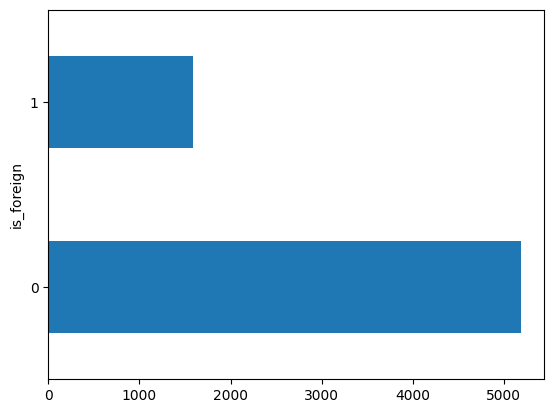

In [58]:
df['is_foreign'] = df['production_countries'].apply(lambda x: 1 if 'us' not in x else 0)
df['is_foreign'].value_counts()
df['is_foreign'].value_counts().plot(kind='barh')
plt.show()

#### Crew

In [59]:
#!TODO: add crew analysis 

In [9]:
import pandas as pd
import ast

df['director_popularity'] = 0
df['director_popularity_list'] = df.apply(lambda x: [], axis=1)
df['director'] = df.apply(lambda x: [], axis=1)
df['writer'] = df.apply(lambda x: [], axis=1)
df['writer_popularity_list'] = df.apply(lambda x: [], axis=1)
df['producer'] = df.apply(lambda x: [], axis=1)
df['producer_popularity_list'] = df.apply(lambda x: [], axis=1)
df['writer_popularity'] = 0
df['producer_popularity'] = 0
df['average_crew_popularity'] = 0
df['number_crew_members'] = 0

def update_popularity(row):
    director = []
    director_popularity_list = []
    writer = []
    writer_popularity_list = []
    producer = []
    producer_popularity_list = []
    director_popularity = 0
    writer_popularity = 0
    producer_popularity = 0
    total_popularity = 0
    num_directors = 0
    num_writers = 0
    num_producers = 0
    num_crew_members = len(row['crew'])
    
    for member in row['crew']:
        job = member.get('job', '')
        name = member.get('name', '')
        popularity = member.get('popularity', 0)
        total_popularity += popularity
        
        if job == 'director':
            director.append(name)
            director_popularity += popularity
            director_popularity_list.append(popularity)
            num_directors += 1
        elif job in ['writer', 'screenplay']:
            writer.append(name)
            writer_popularity += popularity
            writer_popularity_list.append(popularity)
            num_writers += 1
        elif job == 'producer':
            producer.append(name)
            producer_popularity += popularity
            producer_popularity_list.append(popularity)
            num_producers += 1
    
    # Average the popularity for directors, writers, and producers if there are multiple
    director_popularity /= max(num_directors, 1)
    writer_popularity /= max(num_writers, 1)
    producer_popularity /= max(num_producers, 1)
    
    # Compute the average popularity for all crew members
    average_crew_popularity = total_popularity / max(num_crew_members, 1)
    
    return pd.Series([director, director_popularity_list, writer, writer_popularity_list,producer, producer_popularity_list,  average_crew_popularity, num_crew_members])

df[['director', 'director_popularity', 'writer', 'writer_popularity', 'producer', 'producer_popularity', 'average_crew_popularity', 'number_crew_members']] = df.apply(update_popularity, axis=1)

import pandas as pd

def calculate_top_individuals(role_column, popularity_column):
    rows_list = []
    for index, row in df.iterrows():
        for individual, popularity in zip(row[role_column], row[popularity_column]):
            rows_list.append({role_column: individual, 'popularity': popularity})
    role_df = pd.DataFrame(rows_list)
    role_popularity = role_df.groupby(role_column)['popularity'].agg(['mean', 'count'])
    role_popularity = role_popularity.sort_values(by='mean', ascending=False)

    return role_popularity

top_popularity_directors = calculate_top_individuals('director', 'director_popularity')
top_popularity_writers = calculate_top_individuals('writer', 'writer_popularity')
top_popularity_producers = calculate_top_individuals('producer', 'producer_popularity')

top_fr_directors =  top_popularity_directors.sort_values(by='count', ascending=False)
top_fr_writers =  top_popularity_writers.sort_values(by='count', ascending=False)
top_fr_producers =  top_popularity_producers.sort_values(by='count', ascending=False)


In [19]:
top_popularity_directors_reset = top_popularity_directors.head(10).reset_index()
top_popularity_writers_reset = top_popularity_writers.head(10).reset_index()
top_popularity_producers_reset = top_popularity_producers.head(10).reset_index()
top_fr_directors_reset = top_fr_directors.head(10).reset_index()
top_fr_writers_reset = top_fr_writers.head(10).reset_index()
top_fr_producers_reset = top_fr_producers.head(10).reset_index()

combined_df = pd.concat([
    top_popularity_directors_reset, top_fr_directors_reset, top_popularity_writers_reset,  top_fr_writers_reset,
    top_popularity_producers_reset, top_fr_producers_reset
], axis=1)

combined_df.columns = [
    'Top Popularity Directors', 'Popularity','Frequency',
    'Top Frequency Directors', 'Popularity', 'Frequency',
    'Top Popularity Writers', 'Popularity','Frequency',
    'Top Frequency Writers', 'Frequency','Frequency',
    'Top Popularity Producers', 'Popularity','Frequency',
    'Top Frequency Producers', 'Frequency','Frequency',
]

combined_df.style


#### Cast

In [64]:
#!TODO: add cast analysis 

In [65]:
import pandas as pd
import ast

df['average_cast_popularity'] = 0
df['number_cast_members'] = 0
df['top_cast_popularity'] = 0

def update_cast_popularity(row):
    total_popularity = 0
    top_cast_popularity = 0
    num_cast_members = len(row['cast'])
    
    # Sort the cast members by popularity, in descending order
    sorted_cast = sorted(row['cast'], key=lambda x: x.get('popularity', 0), reverse=True)
    
    for idx, member in enumerate(sorted_cast):
        popularity = member.get('popularity', 0)
        total_popularity += popularity
        
        # Sum the popularity of the top 4 cast members
        if idx < 4:
            top_cast_popularity += popularity
    
    # Compute the average popularity for all cast members
    average_cast_popularity = total_popularity / max(num_cast_members, 1)
    
    return pd.Series([average_cast_popularity, num_cast_members, top_cast_popularity])

df[['average_cast_popularity', 'number_cast_members', 'top_cast_popularity']] = df.apply(update_cast_popularity, axis=1)
df[['average_cast_popularity', 'number_cast_members', 'top_cast_popularity']].describe()

average_cast_popularity  number_cast_members  top_cast_popularity
count                  6769.00              6769.00              6769.00
mean                      6.08                35.73                88.98
std                       3.59                25.20                55.72
min                       0.60                 1.00                 0.60
25%                       3.57                19.00                45.82
50%                       5.48                29.00                83.89
75%                       7.90                47.00               122.09
max                      44.34               348.00               489.51

#### Feature importance analysis

In [66]:
df.columns

Index(['title', 'release_year', 'release_month', 'original_language',
       'spoken_languages', 'genres', 'production_companies',
       'production_countries', 'runtime', 'rated', 'tmdb_popularity', 'cast',
       'crew', 'belongs_to_collection.name', 'adjusted_ROI',
       'numerical_ROI_category', 'average_rating', 'numerical_rating_category',
       'award_points', 'numerical_award_category', 'collection', 'is_english',
       'text', 'overview_sentiment', 'title_sentiment', 'tagline_sentiment',
       'plot_sentiment', 'era', 'is_summer', 'is_autumn', 'genres_list',
       'action', 'adventure', 'animation', 'comedy', 'crime', 'drama',
       'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'romance',
       'science fiction', 'thriller', 'unknown', 'war', 'western',
       'num_spoken_languages', 'num_genres', 'num_production_companies',
       'num_production_countries', 'is_foreign', 'director_popularity',
       'director_popularity_list', 'director', 'writer',
 

In [67]:
corr_matrix = df[[ 'title_vector',
       'overview_vector', 'tagline_vector', 'plot_vector',
       'overview_sentiment', 'title_sentiment', 'tagline_sentiment',
       'plot_sentiment', 'adjusted_ROI', 'average_rating', 'award_points']].corr()

# Compute the correlation matrix
for i in range(corr_matrix.shape[0]):
    corr_matrix.iloc[i, i] = 0

plt.figure(figsize=(10, 10)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.show()

max_corr_value = corr_matrix.abs().max().max()
result = corr_matrix.where(corr_matrix == max_corr_value).stack().index.tolist()[0]

print(result)

KeyError: "['title_vector', 'overview_vector', 'tagline_vector', 'plot_vector'] not in index"

In [ ]:
corr_matrix = df[[ "runtime", 'tmdb_popularity', 'num_spoken_languages',
       'num_genres', 'num_production_companies', 'num_production_countries','director_popularity', 'writer_popularity',
       'producer_popularity', 'average_crew_popularity', 'number_crew_members',
       'average_cast_popularity', 'number_cast_members',
       'top_cast_popularity', 'adjusted_ROI', 'average_rating', 'award_points']].corr()

# Compute the correlation matrix
for i in range(corr_matrix.shape[0]):
    corr_matrix.iloc[i, i] = 0

plt.figure(figsize=(10, 10)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.show()

max_corr_value = corr_matrix.abs().max().max()
result = corr_matrix.where(corr_matrix == max_corr_value).stack().index.tolist()[0]

print(result)

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import scipy.stats as ss

for feature in [ 'release_year', 'release_month',  'rated',  'collection',  'is_english', 'era',
                 'is_summer', 'is_autumn', 
       'is_foreign']:
    for label in ['adjusted_ROI', 'average_rating', 'award_points']:
        # Assume df is your DataFrame, and 'categorical_feature' and 'label' are the column names
        print(feature, label)
        contingency_table = pd.crosstab(df[feature], df[label])
        chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table)

        print("Chi2 Stat:", chi2_stat)
        print("P Value:", p_val)

        def cramers_v(confusion_matrix):
            chi2 = ss.chi2_contingency(confusion_matrix)[0]
            n = confusion_matrix.sum().sum()
            phi2 = chi2 / n
            r, k = confusion_matrix.shape
            phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

        cramers_v_value = cramers_v(contingency_table)
        print("Cramer's V:", cramers_v_value)


collection adjusted_ROI
Chi2 Stat: 5626.57250865935
P Value: 0.26267397120856617
Cramer's V: 0.10696274232710096

The p-value of 0.263 indicates that the association between collection and adjusted_ROI is not statistically significant at the common alpha level of 0.05. However, Cramer's V value of 0.107 suggests a weak association between the two variables. This could imply that while there is a pattern, it's not strong enough to be statistically significant. It's advisable to consider other features or a combination of features to improve predictive performance.

era award_points
Chi2 Stat: 7363.202378355073
P Value: 0.0
Cramer's V: 0.33412289423928143

The results indicate a statistically significant association between the era and award_points variables, as evidenced by the p-value of 0.0 (below the common alpha level of 0.05). Additionally, the Cramer's V value of 0.334 suggests a moderate association between these two variables. This might indicate that the era in which a movie was released could have an impact on its award points, and could be a useful feature in predictive modeling.

is_foreign award_points
Chi2 Stat: 367.50493422858233
P Value: 0.0003931583927726182
Cramer's V: 0.12279156977315503

The Chi-square test indicates a statistically significant association between the is_foreign and award_points variables, with a p-value of 0.0004 (which is below the common alpha level of 0.05). The Cramer's V value of 0.123 suggests a small to moderate association between these two variables. This might indicate that whether a movie is foreign or not could have some impact on its award points, making is_foreign a potentially useful feature for analysis or predictive modeling.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import scipy.stats as ss


for feature in [ 'release_year', 'release_month',  'rated',  'collection',  'is_english', 'era',
                 'is_summer', 'is_autumn', 
       'is_foreign']:
    for label in ['numerical_ROI_category', 'numerical_rating_category', 'numerical_award_category']:
        # Assume df is your DataFrame, and 'categorical_feature' and 'label' are the column names
        print(feature, label)
        contingency_table = pd.crosstab(df[feature], df[label])
        chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table)

        print("Chi2 Stat:", chi2_stat)
        print("P Value:", p_val)

        def cramers_v(confusion_matrix):
            chi2 = ss.chi2_contingency(confusion_matrix)[0]
            n = confusion_matrix.sum().sum()
            phi2 = chi2 / n
            r, k = confusion_matrix.shape
            phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

        cramers_v_value = cramers_v(contingency_table)
        print("Cramer's V:", cramers_v_value)


In [ ]:
#df['release_year'] = df['release_year'].astype('str')
#df['release_month'] = df['release_month'].astype('str')

dataset_df = df[['release_year', 'release_month', 'runtime', 'rated', 'collection', 
                 'is_english', 'title_vector',
                'overview_vector', 'tagline_vector', 'plot_vector',
                'overview_sentiment', 'title_sentiment', 'tagline_sentiment',
                'plot_sentiment', 'era', 'is_summer', 'is_autumn',
                'action', 'adventure', 'animation', 'comedy', 'crime', 'drama',
                'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'romance',
                'science fiction', 'thriller', 'war', 'western', 'num_spoken_languages',
                'num_genres', 'num_production_companies', 'num_production_countries',
                'is_foreign', 'director_popularity', 'writer_popularity',
                'producer_popularity', 'average_crew_popularity', 'number_crew_members',
                'average_cast_popularity', 'number_cast_members',
                'top_cast_popularity', 
                'numerical_ROI_category', 'numerical_rating_category', 'numerical_award_category']].copy()
# !TODO: I removed 'tmdb_popularity'!!!!

In [ ]:
from sklearn.model_selection import train_test_split, train_test_split
df_full_train, df_test = train_test_split(dataset_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

#! TODO: need to understand distribution of labels

X_train = df_train.reset_index(drop=True)
X_val = df_val.reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

y_train = df_train[['numerical_ROI_category', 'numerical_rating_category', 'numerical_award_category']].copy()
y_val = df_val[['numerical_ROI_category', 'numerical_rating_category', 'numerical_award_category']].copy()
y_test = df_test[['numerical_ROI_category', 'numerical_rating_category', 'numerical_award_category']].copy()

X_train.drop(['numerical_ROI_category', 'numerical_rating_category', 'numerical_award_category'], axis=1, inplace=True)
X_val.drop(['numerical_ROI_category', 'numerical_rating_category', 'numerical_award_category'], axis=1, inplace=True)
X_test.drop(['numerical_ROI_category', 'numerical_rating_category', 'numerical_award_category'], axis=1, inplace=True)

from sklearn.preprocessing import StandardScaler



# Now use X_train_scaled and X_val_scaled instead of X_train and X_val in your loop.
dv = DictVectorizer(sparse=False)
X_train_t = dv.fit_transform(X_train.to_dict(orient='records'))
X_val_t = dv.transform(X_val.to_dict(orient='records'))

# Scale the data
scaler = StandardScaler()
X_train_t = scaler.fit_transform(X_train_t)
X_val_t = scaler.transform(X_val_t)


#### RandomForestClassifier feature importance for 'numerical_ROI_category', 'numerical_rating_category', 'numerical_award_category'

In [ ]:
from sklearn.ensemble import RandomForestClassifier

for label in ['numerical_ROI_category', 'numerical_rating_category', 'numerical_award_category']:
    rf = RandomForestClassifier(random_state=1)
    rf.fit(X_train_t, y_train[label])

    # Get feature importances
    importances = rf.feature_importances_

    # Match importances with feature names
    feature_importances = pd.DataFrame({'feature': dv.get_feature_names_out(), 'importance': importances})
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    sns.set_style('whitegrid')
    plt.figure(figsize=(10,12))
    sns.barplot(x='importance', y='feature', data=feature_importances.sort_values('importance', ascending=False))
    plt.title(f'Feature Importance for {label}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()


#### MultiOutputClassifier feature importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer

# Assuming your data preparation steps are correct and already executed

# Training MultiOutputClassifier with RandomForest
forest = RandomForestClassifier(random_state=1, n_jobs=-1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_target_forest.fit(X_train_t, y_train)

# Getting feature importances
importances = multi_target_forest.estimators_[0].feature_importances_

# Getting feature names
feature_names = dv.get_feature_names_out()

# Creating a DataFrame for feature importances
df_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sorting the features based on importance
df_importances = df_importances.sort_values(by='importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 12))
sns.barplot(x='importance', y='feature', data=df_importances)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
dataset = df[['release_year', 'release_month', 'runtime', 'rated', 'collection', 
                 'is_english', 'title_vector',
                'overview_vector', 'tagline_vector', 'plot_vector',
                'overview_sentiment', 'title_sentiment', 'tagline_sentiment',
                'plot_sentiment', 'era', 'is_summer', 'is_autumn',
                'action', 'adventure', 'animation', 'comedy', 'crime', 'drama',
                'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'romance',
                'science fiction', 'thriller', 'war', 'western', 'num_spoken_languages',
                'num_genres', 'num_production_companies', 'num_production_countries',
                'is_foreign', 'director_popularity', 'writer_popularity',
                'producer_popularity', 'average_crew_popularity', 'number_crew_members',
                'average_cast_popularity', 'number_cast_members',
                'top_cast_popularity', 'numerical_ROI_category', 'numerical_rating_category', 'numerical_award_category']]

dataset.to_parquet('dataset.parquet')


In [ ]:
dataset.dtypes